In [5]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dissertation/Space Intelligence/')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 checkpoints
'Copy of cyclegan.ipynb'
'Copy of pix2pix.ipynb'
 Data
 Exploration_Models_Analysis.ipynb
'Filling the GAPS S-CycleGAN_Attempt.ipynb'
 JRH_Filling_the_GAPS_Build_Training_Sets.ipynb
 JRH_Filling_the_Gaps_Image_Generation2.ipynb
 JRH_Filling_the_Gaps_Image_Generation.ipynb
 JRH_Filling_the_Gaps_Model_Building.ipynb
 logs
 output_images
 pix2pix_cGAN
 S-CycleGAN_Attempt.ipynb


Setup environment

In [1]:
#Installations
%%capture
!apt install gdal-bin python-gdal python3-gdal ##base software for rasterio
!pip install rasterio ##raster image handling
!pip install lightgbm ##for an improvement on decision trees
!pip install xgboost ##for an improvement on decision trees

In [2]:
##import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
import shutil
import re
import itertools
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import plotly.graph_objects as go ##for tables
import gc ##for garbage collect/memory management
from rasterio.plot import show
from os.path import isfile, join
from natsort import natsorted, index_natsorted  ##natural sorting of strings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, classification_report, precision_recall_fscore_support

In [6]:
##Load Data (Images and Training/Testing/Validation Data)

##Only loading one image/dataset at a time due to computational limits
##(We do load all cloud variations for an image though)
##choose which to load here:
choose_ind = 0

##creating directory strings
data_dir = os.getcwd() + "/Data"
sen1_dir = data_dir + "/s1_filled"
sen2_dir = data_dir + "/s2_reproject" ##reading in the cloudy images for training
sen2_dir_cloud = data_dir + "/sen2_circle_cloud" ##reading in the cloudy images for training
numpy_masks_dir = data_dir + "/numpy_cloud_masks"  ##parent directory for all cloud masks
lin_mod_directory = join(data_dir, "Linear_Model_Data") ##parent directory for all training/test sets

##List image names for sentinel 1 and 2 (NOT full path)
sen1_images = [join(sen1_dir,f) for f in os.listdir(sen1_dir) if isfile(join(sen1_dir, f))]
sen2_images = [join(sen2_dir,f) for f in os.listdir(sen2_dir) if isfile(join(sen2_dir, f))]


##List file names for numpy masks for each image/random cloud
pattern_names = ["aoi_" + str(i+1) for i in range(len(sen2_images))]
numpy_masks_images = [join(numpy_masks_dir, f"{name}_numpy_masks") for name in pattern_names]
cloud_mask_f = [None] * len(numpy_masks_images) ##initialize list for cloud files

for i in range(len(numpy_masks_images)):
  cloud_mask_f[i] = [join(numpy_masks_images[i], f) for f in natsorted(os.listdir(numpy_masks_images[i]))] ##get file names for each image


##order file names according to ao1_{number}
sen1_number = [re.search(r'(?<=_)[0-9]+', i).group() for i in sen1_images] ##gets ao1 number for sen1
sen1_images = [sen1_images[i] for i in index_natsorted(sen1_number)] ##sorts according to sorted sen1_number

sen2_number = [re.search(r'(?<=_)[0-9]+', i).group() for i in sen2_images] ##gets ao1 number for sen2
sen2_images = [sen2_images[i] for i in index_natsorted(sen2_number)] ##sorts according to sorted sen2_number

##read raster objects ()
sen1_datasets = rio.open(sen1_images[choose_ind])
sen2_datasets = rio.open(sen2_images[choose_ind])
# sen1_datasets = [rio.open(join(sen1_dir,f)) for f in sen1_images]## read sen1 into a list 
# sen2_datasets = [rio.open(join(sen2_dir,f)) for f in sen2_images]## read sen2 into a list  

##get cloud directory names based on pattern used to create them
sen2_cloud_dirs = [join(sen2_dir_cloud, f"aoi_{i+1}_clouds") for i in range(len(sen2_images))]

##Get train/test directory names based on pattern used to create them
training_dirs = [join(lin_mod_directory, f"aoi_{i+1}_data/aoi_{i+1}_training") for i in range(len(sen2_images))]
testing_dirs = [join(lin_mod_directory, f"aoi_{i+1}_data/aoi_{i+1}_testing") for i in range(len(sen2_images))]



In [7]:
##Again, we load only one image (aoi_number) at a time, but we DO
##load all of the cloud masks for that image for an uncertainty analysis

##Name the train, test, validation columns according to the order created (4 y_vars, VV X, VH X, VV/VH X)
x_col_patt = ["top_left", "top", "top_right", "left", "center", "right", "bottom_left", "bottom", "bottom_right"] ##x pattern
x_cols = ["VV_" + s for s in x_col_patt] + ["VH_" + s for s in x_col_patt] + ["VV_VH_" + s for s in x_col_patt]##all x column names
y_cols = ["y_red", "y_green", "y_blue", "y_nir"] ##y column names
colnames = y_cols + x_cols ##all column names

##Load train/test files into a list and then load the datasets of interest as a pandas dataframe (datasets for all 10 random clouds)
##will be a list of pandas dataframes containing the training/testing data for an individual cloud mask
train_files = [None] * len(sen2_images)
test_files = [None] * len(sen2_images)

for i in range(len(sen2_images)): 
  train_files[i] = [join(training_dirs[i], f) for f in natsorted(os.listdir(training_dirs[i]))] ##get file names for each image
  test_files[i] = [join(testing_dirs[i], f) for f in natsorted(os.listdir(testing_dirs[i]))] ##get file names for each image

train_sets = [pd.DataFrame(np.load(f), columns = colnames) for f in train_files[choose_ind]]
test_sets = [pd.DataFrame(np.load(f), columns = colnames) for f in test_files[choose_ind]]


##Load Cloud Images (All 10 for uncertainty analysis)
sen2_cloud_im = [None] * len(sen2_cloud_dirs) ##initialize list for filenames of all 10 iages

for i in range(len(sen2_images)):
  sen2_cloud_im[i] = [join(sen2_cloud_dirs[i], f) for f in natsorted(os.listdir(sen2_cloud_dirs[i]))] ##get file names for all images

sen2_clouds = [rio.open(join(sen2_dir_cloud[choose_ind],f)) for f in sen2_cloud_im[choose_ind]]## read sen2 clouds for selected aoi image

####Load Cloud Mask Arrays for Each Cloud in the chosen aoi index
cloud_mask_arrays = [np.load(f) for f in cloud_mask_f[choose_ind]]


In [8]:
##Calculate true ndvi for train and test results


##update new columns and specify desired order
y_cols = ["y_red", "y_green", "y_blue", "y_nir", "y_ndvi"] ##y columns with ndvi added
colnames = y_cols + x_cols ##new column names with y_ndvi added right after y_nir instead of the end

for i in range(len(test_sets)):
  ##add ndvi to train
  train_sets[i]["y_ndvi"] = (train_sets[i]["y_nir"] - train_sets[i]["y_red"]) / (train_sets[i]["y_nir"] + train_sets[i]["y_red"])
  train_sets[i] = train_sets[i].reindex(columns = colnames) ##reindex to get columns in desired order

  ##add ndvi to test
  test_sets[i]["y_ndvi"] = (test_sets[i]["y_nir"] - test_sets[i]["y_red"]) / (test_sets[i]["y_nir"] + test_sets[i]["y_red"])
  test_sets[i] = test_sets[i].reindex(columns = colnames) ##reindex to get columns in desired order


##Exploratory Data Analysis

The first step for analysis is to plot the fully processed images

In [9]:
##Make Directory for output files
output_dir = "./output_images"
if not os.path.exists(output_dir):
  os.mkdir(output_dir)
  print("Directory Created!")



##Write function to normalize images to 0-1 scale for RGB plotting
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))


###########################################################################################


##Write function to invert normalization
def invert_normalize(normalized_array, original_min, original_max):

  inverted = normalized_array * (original_max - original_min) + original_min
  return inverted


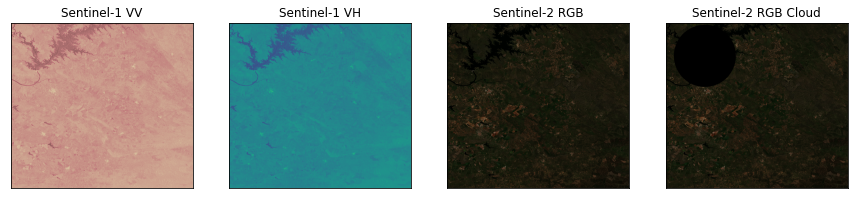

In [8]:
##plotting Sen1 VV, Sen1 VH, Sen2 RGB, and one Sen2 Cloud RGB

##Plot images
fig, ax = plt.subplots(ncols = 4, figsize = (15,8))

ax[0].imshow(normalize(sen1_datasets.read(1)), cmap = "pink") ##Sen1 VV
ax[1].imshow(normalize(sen1_datasets.read(2))) ##Sen1 VV
ax[2].imshow(normalize(np.transpose(sen2_datasets.read([3,2,1]), (1,2,0)))) ##RGB
ax[3].imshow(normalize(np.transpose(sen2_clouds[0].read([3,2,1]), (1,2,0))))

##Name subfigures
subfig_titles = ["Sentinel-1 VV", "Sentinel-1 VH", "Sentinel-2 RGB", "Sentinel-2 RGB Cloud"]
for i in range(4):
  ax[i].set(xticks = [], yticks = [], title = subfig_titles[i])

plt.savefig(join(output_dir, "Representative_Images.png"))


Now that we have a training set with a feature matrix, we can explore the data to see if a linear model is a valid approach.

We will explore the distribution of pixel intensities in each of the SAR and optical bands to see if any transformations are required (primarily for the baseline linear model, but they may be useful for preprocessing for a deep learning model). Additionally, we will visualize relationships between SAR pixel intensities and the outcome variable: an individual optical band pixel value.

Kernel Density Estimation Plots for outcome variables
(Commented Out For Memory)

In [9]:
# ##Get kernel density plots for each y-variable (testing for normality)
# fig, ax = plt.subplots(nrows = len(test_sets),ncols = 4, figsize = (20,15))

# ##Plot kdeplots for all images and colors (red, blue, green, nir)
# ##ONLY plot first 100,000 (Randomized so it doesn't matter) for memory and computational time
# titles = ["Sentinel-2: Red", "Sentinel-2: Green", "Sentinel-2: Blue", "Sentinel-2: NIR"]
# plot_n = 50000
# for i in range(len(test_sets)):
#   for j in range(4):
#     if i == 0:
#       sns.kdeplot(data=train_sets[i].head(plot_n), x=y_cols[j], ax = ax[i,j]).set_title(titles[j])
#     else:
#       sns.kdeplot(data=train_sets[i].head(plot_n), x=y_cols[j], ax = ax[i,j])

In [10]:
# ##Get kernel density plots for each y-variable (testing for normality) log transformed
# fig, ax = plt.subplots(nrows = len(test_sets),ncols = 4, figsize = (15,8))

# ##Plot kdeplots for all images and colors (red, blue, green, nir)
# titles = ["Sentinel-2: Red", "Sentinel-2: Green", "Sentinel-2: Blue", "Sentinel-2: NIR"]

# for i in range(len(test_sets)):
#   image_selected = pattern_names[i]
#   for j in range(4):
#     if i == 0:
#       sns.kdeplot(x=np.log(train_sets[i].head(plot_n)[y_cols[j]]), ax = ax[i,j]).set_title(titles[j])
#     else:
#       sns.kdeplot(x=np.log(train_sets[i].head(plot_n)[y_cols[j]]), ax = ax[i,j])

In [11]:
# ##Get kernel density plots for each y-variable (testing for normality)
# fig, ax = plt.subplots(nrows = len(test_sets),ncols = 4, figsize = ( 20,20))

# ##Plot kdeplots for all images and colors (red, blue, green, nir)
# titles = ["Sentinel-2: Red", "Sentinel-2: Green", "Sentinel-2: Blue", "Sentinel-2: NIR"]

# for i in range(len(test_sets)):
#   image_selected = pattern_names[i]
#   for j in range(4):
#     if i == 0:
#       sns.histplot(data=train_sets[i].head(plot_n), x=y_cols[j], ax = ax[i,j]).set_title(titles[j])
#     else:
#       sns.histplot(data=train_sets[i].head(plot_n), x=y_cols[j], ax = ax[i,j])

Now we will plot our x-axis variables against y for image-1 only (representative image). We do both y in regular and y in log scale

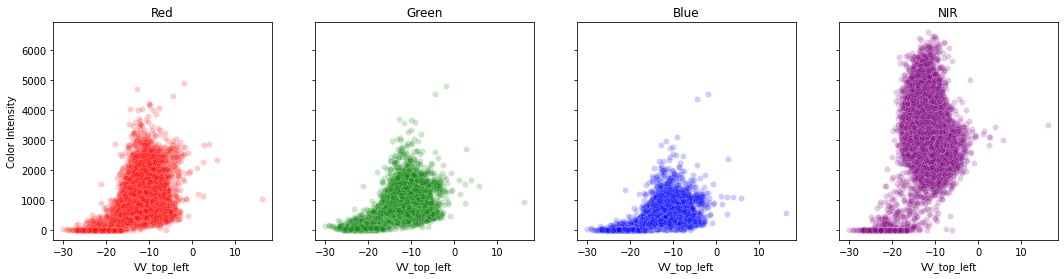

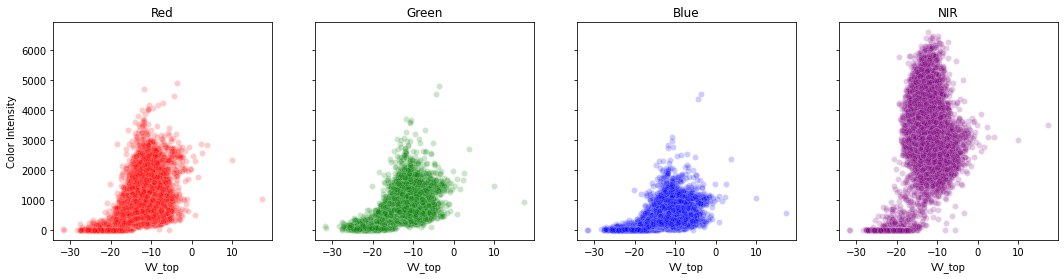

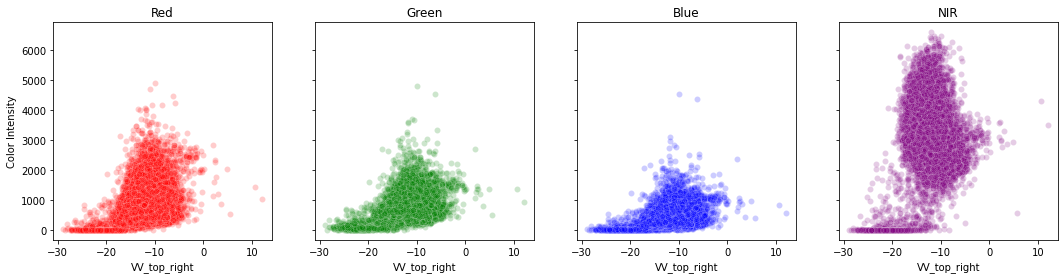

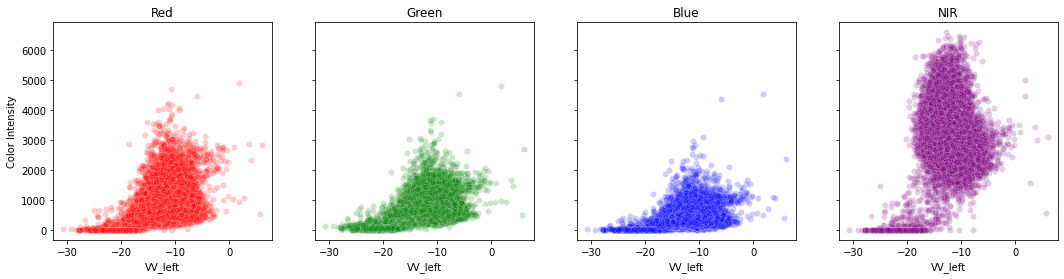

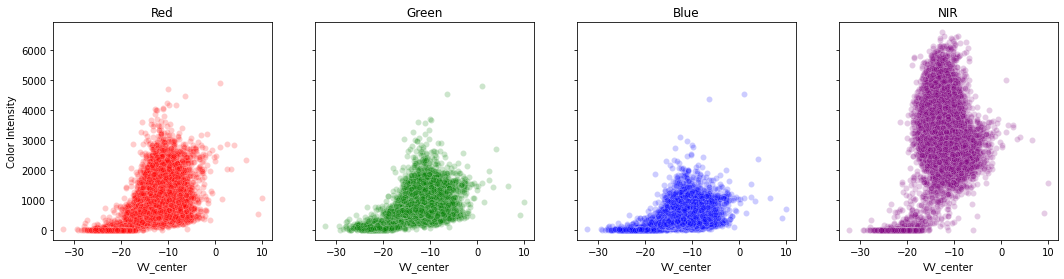

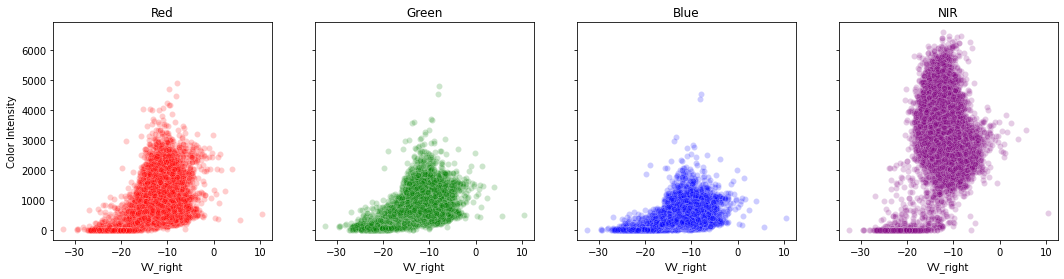

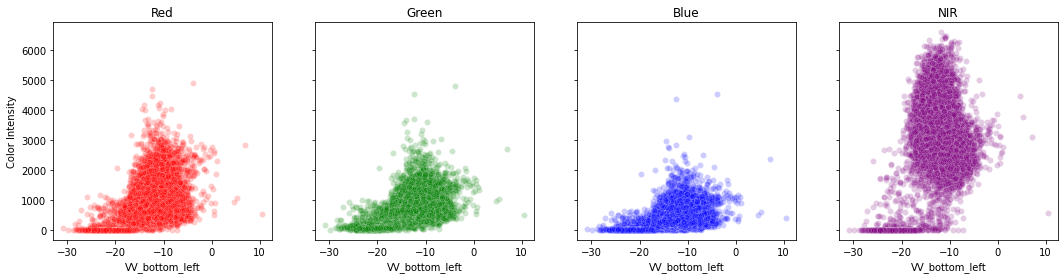

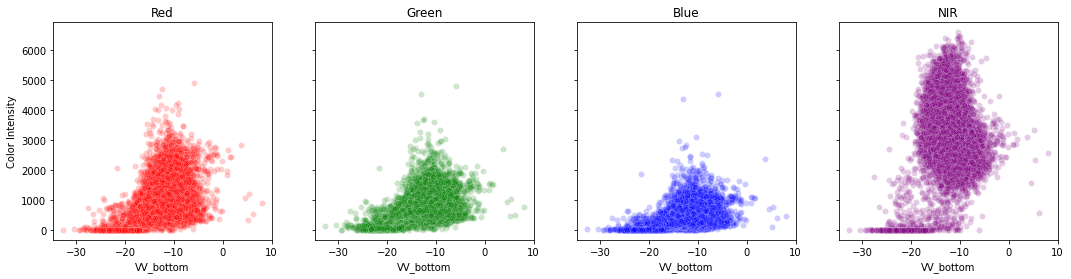

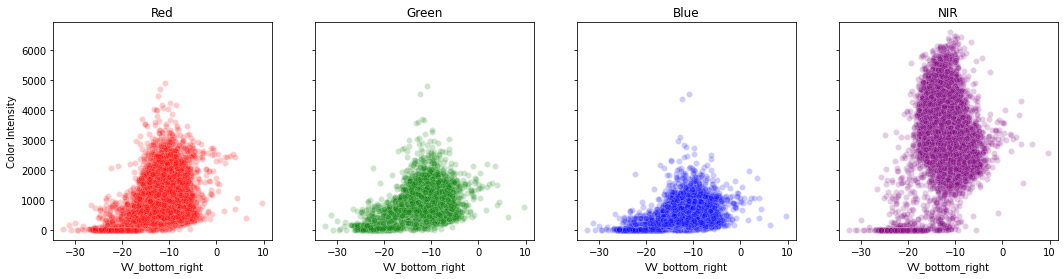

In [12]:
##Plot VV against y (regular scale)
plot_n = 50000
plot_colors = ["red", "green", "blue", "purple"]
titles = ["Red", "Green", "Blue", "NIR"]
for i in range(9):
  fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (18,4), sharey = True)

  for j in range(4):
    sns.scatterplot(data = train_sets[0].head(plot_n), x = x_cols[i], y = y_cols[j], 
                    ax = ax[j], alpha = 0.2, color = plot_colors[j]).set(title = titles[j], ylabel = "Color Intensity")

  ##save only center and top left
  if x_cols[i] == "VV_bottom_right" or x_cols[i] == "VV_center":
    plt.savefig(join(output_dir, f"{x_cols[i]}_vs_colors.png"))

  plt.show()

There appears to be unique distributions separated at about the VV = -18 mark

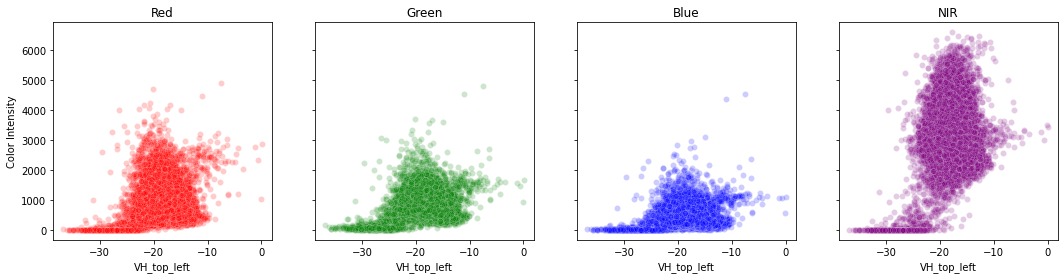

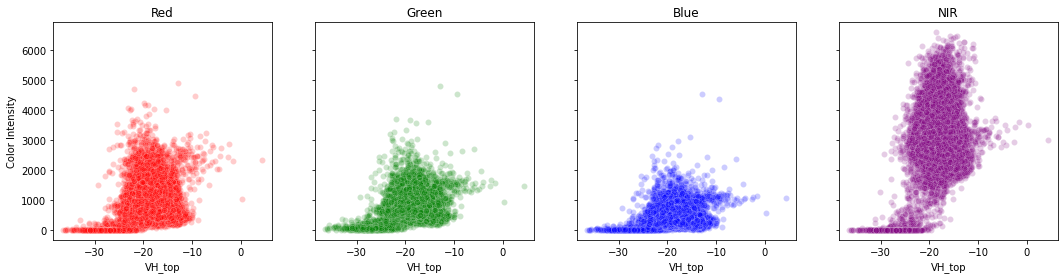

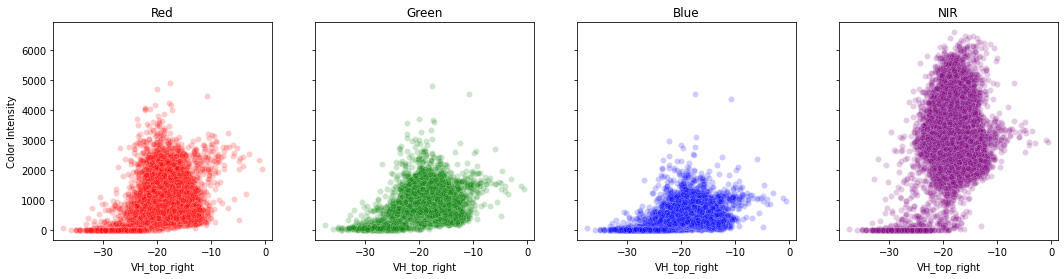

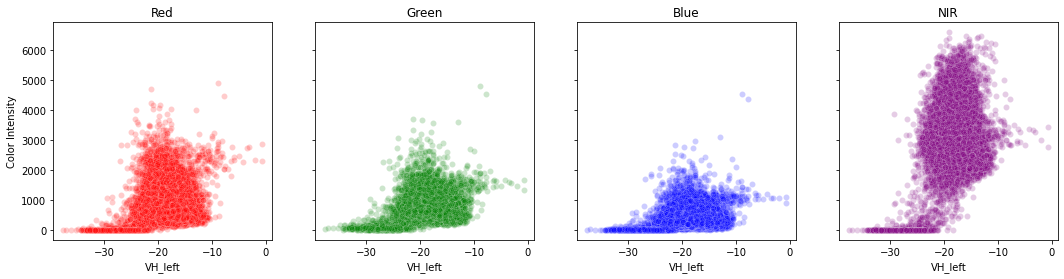

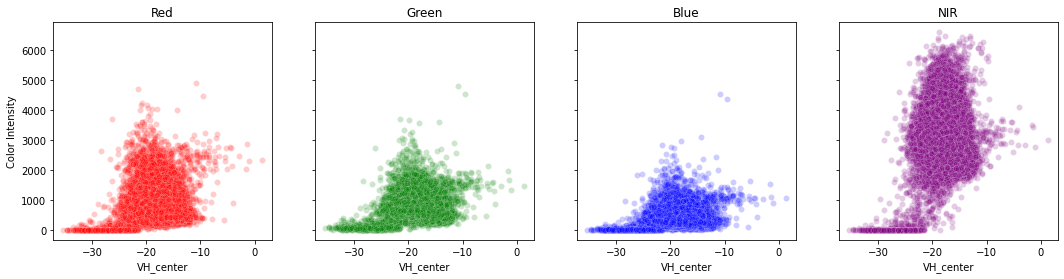

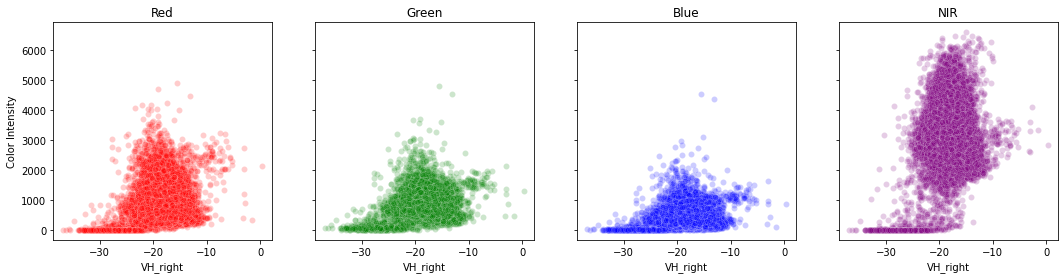

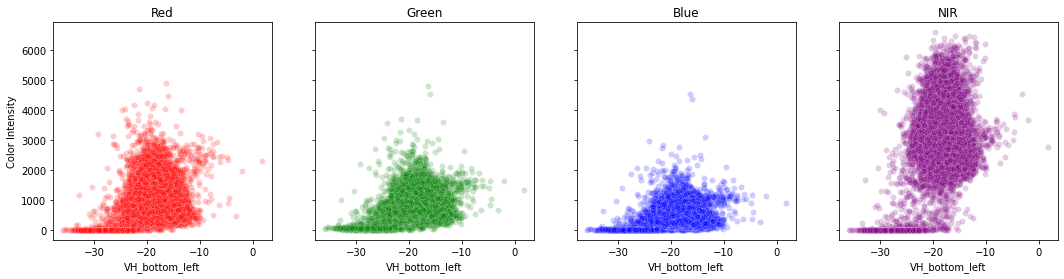

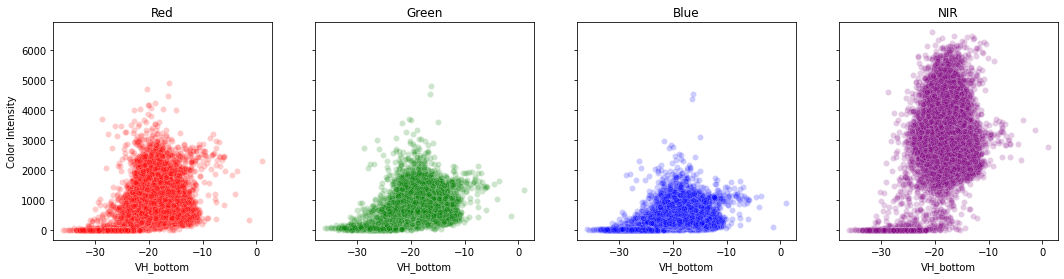

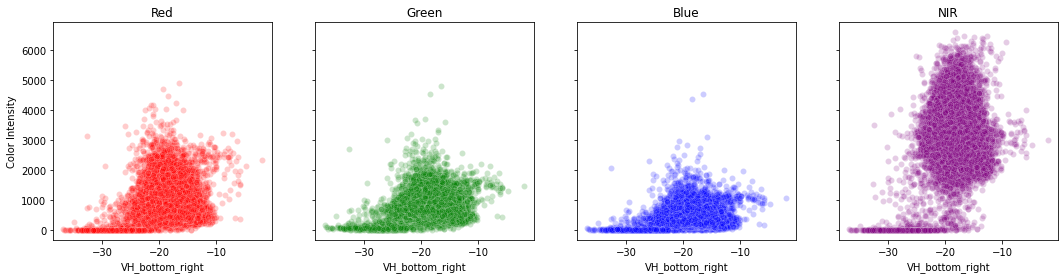

In [13]:
# ##Plot VH (log scale)

plot_n = 50000
plot_colors = ["red", "green", "blue", "purple"]
titles = ["Red", "Green", "Blue", "NIR"]
for i in range(9,18):
  fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (18,4), sharey = True)

  for j in range(4):
    sns.scatterplot(data = train_sets[0].head(plot_n), x = x_cols[i], y = y_cols[j], 
                    ax = ax[j], alpha = 0.2, color = plot_colors[j]).set(title = titles[j], ylabel = "Color Intensity")

  if x_cols[i] == "VH_bottom_right" or x_cols[i] == "VH_center":
    plt.savefig(join(output_dir, f"{x_cols[i]}_vs_colors.png"))
  plt.show()

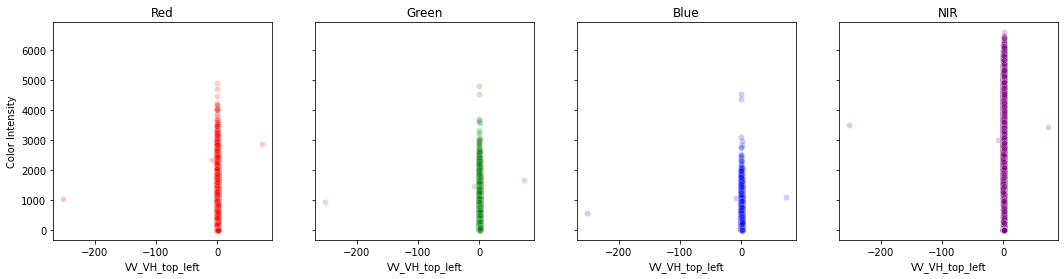

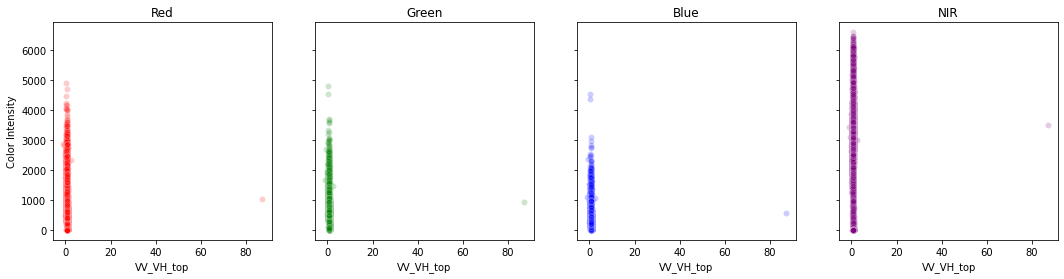

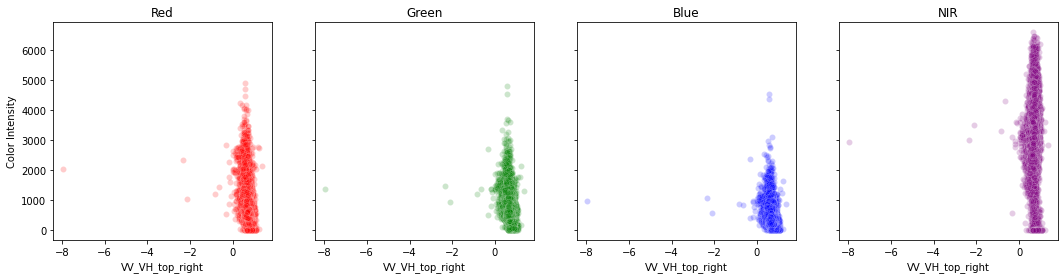

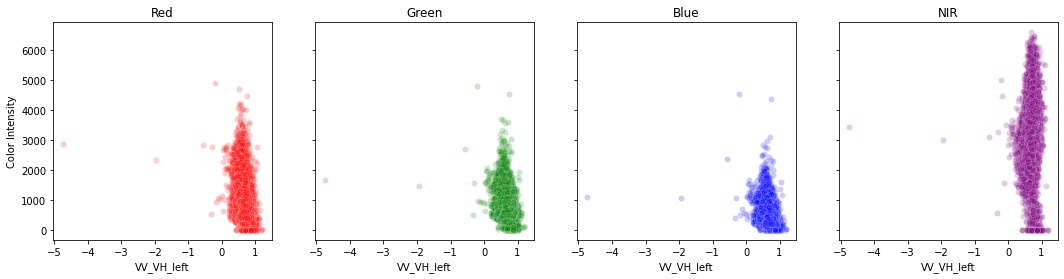

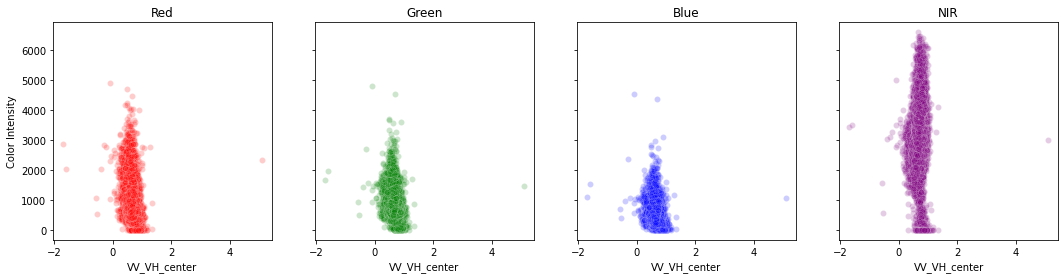

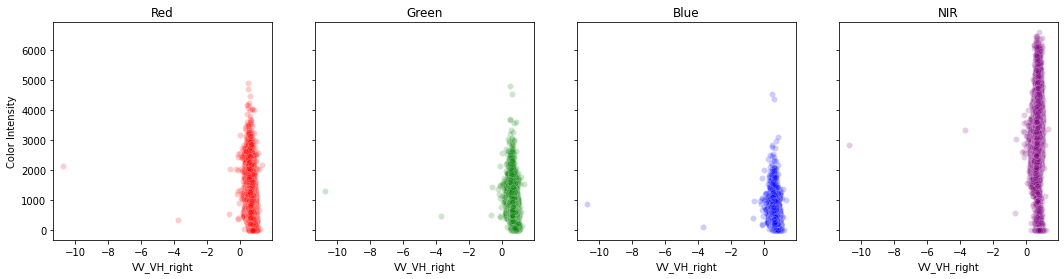

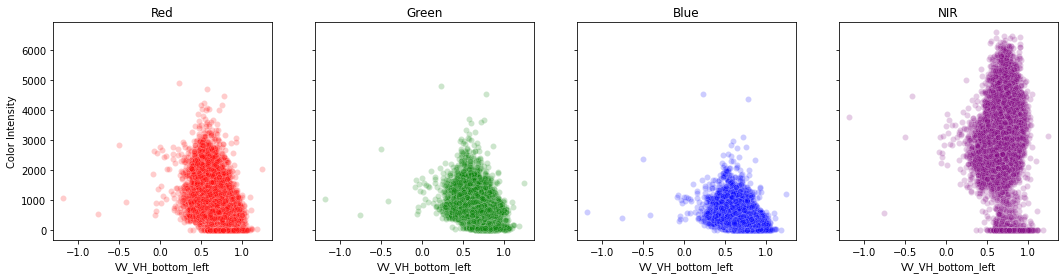

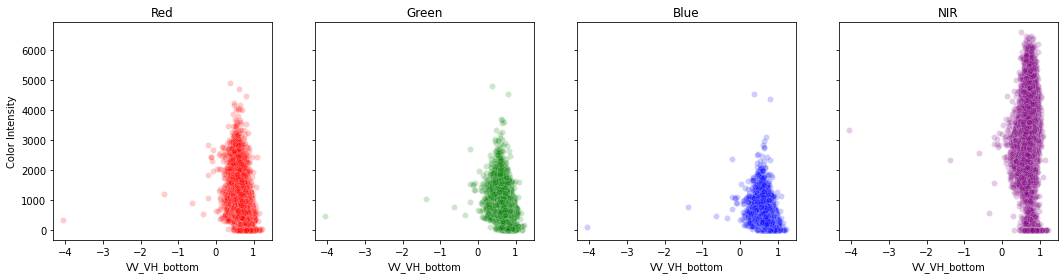

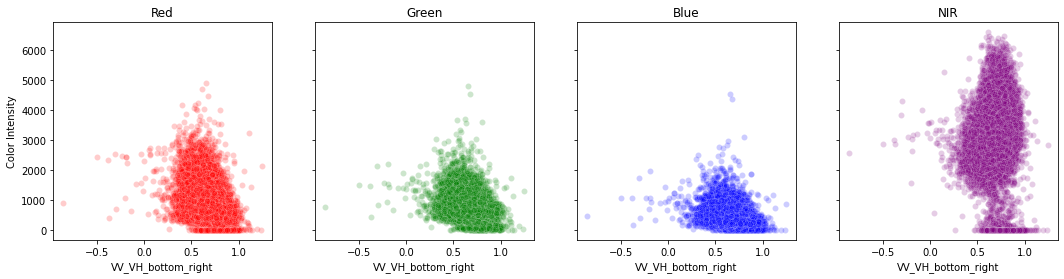

In [14]:
# ##Plot VV/VH (log scale)

plot_n = 50000
plot_colors = ["red", "green", "blue", "purple"]
titles = ["Red", "Green", "Blue", "NIR"]
for i in range(18,27):
  fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (18,4), sharey = True)

  for j in range(4):
    sns.scatterplot(data = train_sets[0].head(plot_n), x = x_cols[i], y = y_cols[j], 
                    ax = ax[j], alpha = 0.2, color = plot_colors[j]).set(title = titles[j], ylabel = "Color Intensity")

  if x_cols[i] == "VV_VH_bottom_right" or x_cols[i] == "VV_VH_center":
    plt.savefig(join(output_dir, f"{x_cols[i]}_vs_colors.png"))
  plt.show()

There appears to be unique distributions separated at about the VH = -28 mark

Due to this bimodal distribution, a linear model will likely not predict well or consistently. As such, we will choose additional models that are robust against non-linear relationships like a decision tree regressor and a gradient boosting regressor.

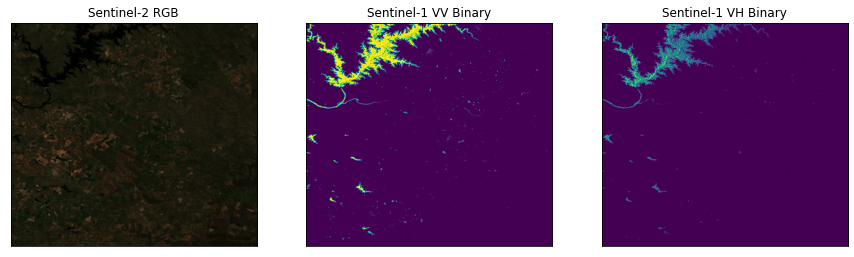

In [15]:
##Given the unique distributions we will plot a binary plot for the pixels where VV is below -18 and VH is below -20 in the image
binary_plot_VV = np.where(sen1_datasets.read(1) < -18, 1, 0) ##binary for VV
binary_plot_VH = np.where(sen1_datasets.read(2) < -28, 1, 0) ##binary for VH

fig, ax = plt.subplots(ncols = 3, figsize = (15,8))
ax[0].imshow(normalize(np.transpose(sen2_datasets.read([3,2,1]), (1,2,0))))
ax[1].imshow(binary_plot_VV, cmap = "viridis")
ax[2].imshow(binary_plot_VH, cmap = "viridis")

##set titles
subfig_titles = ["Sentinel-2 RGB", "Sentinel-1 VV Binary", "Sentinel-1 VH Binary"]
for i in range(3):
  ax[i].set(xticks = [], yticks = [], title = subfig_titles[i])

plt.savefig(join(output_dir, "Binary_Masks.png"))
# plt.suptitle("Sentinel-1 VV and VH Binary Plots Describing Bimmodal Relationship Between Radar and Color Images")

VV/VH is clearly uncorrelated with y-values, so it will be dropped. VV and VH appear to have different relations depending on the output channel, which provides evidence for using different models. Additionally, log transformed VV and VH appear to be more linear than untransformed VV and VH for the red, green, and blue channels while untransformed is better for the NIR channel. However, there are zero values for the VV and VH, so the log transformation is not possible.

We will test with no transformations first, and then we will apply the log transformations to red, green, and blue to see how the results compare

## Model Assessments and Statistics

Write helper functions for regression, plotting, and statistics

In [36]:

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


##write helper function that takes a cloudy image, selected band for regression,
##regression's predicted results, and the cloud mask 
##and returns an image (in the supplied channel) with the cloud filled in with prediction results

def fill_cloud_image(cloudy_image, band_index, cloud_predicted_values, cloud_mask):

  ##read in the array corresponding to the chosen color band for this regression
  ##And copy the image array to another that we will fill in
  sen2_full = cloudy_image[:,:,band_index] ##the band index is for arrays
  sen2_filled = sen2_full.copy()

  ##Unravel the image to a 1D array
  ##find the 1D indices for the cloud in an unraveled array
  ##replace the original values in the array with the predicted values at the 1D indices
  ##Reshape back to original image size
  one_dim_cloud_ind = np.ravel_multi_index(np.where(cloud_mask == 1), dims = sen2_filled.shape) ##1D cloud indices
  sen2_filled = np.ravel(sen2_filled) ##unravel so we call fill with predicted values
  sen2_filled[one_dim_cloud_ind] = cloud_predicted_values ##Place predicted values in the unraveled array at correct location
  sen2_filled = sen2_filled.reshape(sen2_full.shape) ##reshape to original shape

  ##return filled in band
  return sen2_filled

############################################################################################################

##write function to perform RandomizedSearchCV for an estimator using X and y values given a parameter dictionary
def RandomCV(estimator, train_data, x_cols, param_distributions, sample_size, seed, add_intercept = True):
  
  ##Get y and X
  y_vec = [train_data["y_red"], train_data["y_green"], train_data["y_blue"], train_data["y_nir"]]
  X = train_data[x_cols]

  ##Add intercept to X and cloud_vals if we want an intercept
  if add_intercept == True:
    X = np.concatenate((np.ones(shape = (X.shape[0], 1)), X), axis = 1)

  ##Subset X and y for faster cross-val
  np.random.seed(seed)
  N = X.shape[0] ##get total sample size
  ind = np.random.choice(range(N), sample_size) ##get random indices for subset for training
  X = X[ind, :] ##select indices
  y_vec = [vec[ind] for vec in y_vec] ##select indices
  

  ##5 Fold CV
  ##No need to redturn train score because we just select best estimator
  best_estimators = {"red": None, "green": None, "blue": None, "nir": None}
  colors = ["red", "green", "blue", "nir"] ##list used to add to best_estimators list

  ##loop over colors to get best estimator for each
  for i in range(4): 
    ##prepare 5-fold cross-val
    dt_rscv = RandomizedSearchCV(estimator=estimator, 
                                  param_distributions=param_distributions, 
                                  n_iter = 20, cv = 5, 
                                  verbose=2, 
                                  n_jobs=-1, return_train_score=False)
    
    ##perform cross-val on each color
    dt_rscv.fit(X, y_vec[i])
    best_estimators[colors[i]] = dt_rscv.best_estimator_
  

  ##return the best estimators
  return best_estimators

############################################################################################################

def GridCV(estimator, train_data, param_grid, sample_size, seed, add_intercept = True):

  ##Get y and X
  y_vec = [train_data["y_red"], train_data["y_green"], train_data["y_blue"], train_data["y_nir"]]
  X = train_data[x_cols]

  ##Add intercept to X and cloud_vals if we want an intercept
  if add_intercept == True:
    X = np.concatenate((np.ones(shape = (X.shape[0], 1)), X), axis = 1)

  ##Subset X and y for faster cross-val
  np.random.seed(seed)
  N = X.shape[0] ##get total sample size
  ind = np.random.choice(range(N), sample_size) ##get random indices for subset for training
  X = X[ind, :] ##select indices
  y_vec = [vec[ind] for vec in y_vec] ##select indices
  

  ##5 Fold CV
  ##No need to redturn train score because we just select best estimator
  best_estimators = {"red": None, "green": None, "blue": None, "nir": None}
  colors = ["red", "green", "blue", "nir"] ##list used to add to best_estimators list

  ##loop over colors to get best estimator for each
  for i in range(4): 
    ##prepare 5-fold cross-val
    dt_rscv = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid,
                           cv = 5, 
                           verbose=2, 
                           n_jobs=-1, return_train_score=False)
    
    ##perform cross-val on each color
    dt_rscv.fit(X, y_vec[i])
    best_estimators[colors[i]] = dt_rscv.best_estimator_
  

  ##return the best estimators
  return best_estimators

############################################################################################################
##write function to classify NDVI values into traditional land-type classification

def classify_NDVI(ndvi):
  ##Adapted from https://earthpy.readthedocs.io/en/v0.6.8/_downloads/a50a7c2437671f789ec3f30690f1522f/plot_calculate_classify_ndvi.py

  ##specify bins
  ##Values under 0 are considered No vegetaion. Also created Bare Area, Low Vegetation, Moderate Vegetation, and High Vegetation
  ndvi_bins = [-np.inf, 0, 0.1, 0.25, 0.4, np.inf]
  ndvi_class_names = ["No Vegetation","Bare Area","Low Vegetation","Moderate Vegetation","High Vegetation"]

  ##cut and bin the ndvi values
  ndvi_cat = np.digitize(ndvi, ndvi_bins)

  # ##rename as the ndvi_class names
  # condlist = [ndvi_cat == 1, ndvi_cat == 2, ndvi_cat == 3, ndvi_cat == 4, ndvi_cat == 5]
  # ndvi_renamed = np.select(condlist, ndvi_class_names, default='unknown').astype(str)
  
  return ndvi_cat


############################################################################################################

##write function to perform linear models, predict results for clouds, and plot results
def linear_predict(y_vec, X, cloud_vals, cloud_mask, cloudy_image, RGBA_band_order, alpha = 0.05, add_intercept = True):
  ##No actual option for cross-validating and finding the best estimator, but needed so it matches the format of the rest

  ##unpack y vector
  y_red, y_green, y_blue, y_nir = [i for i in y_vec]
  
  ##Add intercept to X and cloud_vals if we want an intercept
  if add_intercept == True:
    X = np.concatenate((np.ones(shape = (X.shape[0], 1)), X), axis = 1)
    cloud_vals = np.concatenate((np.ones(shape = (cloud_vals.shape[0], 1)), cloud_vals), axis = 1)

  ##get linear regression results
  reg_red= sm.OLS(y_red, X).fit()
  reg_green= sm.OLS(y_green, X).fit()
  reg_blue= sm.OLS(y_blue, X).fit()
  reg_nir= sm.OLS(y_nir, X).fit()

  ##get prediction results (for both mean value and for prediction interval)
  red_pred_res = reg_red.get_prediction(cloud_vals)
  green_pred_res = reg_green.get_prediction(cloud_vals)
  blue_pred_res = reg_blue.get_prediction(cloud_vals)
  nir_pred_res = reg_nir.get_prediction(cloud_vals)


  ##get mean prediction  values for each color and round to np.uint16 because this is the type for sen-2 values
  red_predicted = np.round(red_pred_res.predicted_mean).astype(np.uint16) ##predict, round, and convert types
  green_predicted = np.round(green_pred_res.predicted_mean).astype(np.uint16) ##predict, round, and convert types
  blue_predicted = np.round(blue_pred_res.predicted_mean).astype(np.uint16) ##predict, round, and convert types
  nir_predicted = np.round(nir_pred_res.predicted_mean).astype(np.uint16) ##predict, round, and convert types


  ##We do not want to predict values too far outside the range of values in the cloudy image,
  ##so we will clip the predicted values to 1.1 times the max and 0.9 times min values in the cloudy image
  min_allowed = np.min(cloudy_image)*0.9
  max_allowed = np.max(cloudy_image)*1.1

  ##correcting mins
  red_predicted[np.where(red_predicted < min_allowed)] = min_allowed
  green_predicted[np.where(green_predicted < min_allowed)] = min_allowed
  blue_predicted[np.where(blue_predicted < min_allowed)] = min_allowed
  nir_predicted[np.where(nir_predicted < min_allowed)] = min_allowed

  ##correcting maxes
  red_predicted[np.where(red_predicted > max_allowed)] = max_allowed
  green_predicted[np.where(green_predicted > max_allowed)] = max_allowed
  blue_predicted[np.where(blue_predicted > max_allowed)] = max_allowed
  nir_predicted[np.where(nir_predicted > max_allowed)] = max_allowed

  ##calculate ndvi from predicted
  ndvi_predicted = (nir_predicted - red_predicted)/(nir_predicted + red_predicted) ##calculate ndvi

  ##combine predicted values into dictionary for return
  predicted_dict = {"red": red_predicted, "green": green_predicted, "blue": blue_predicted, 
                    "nir": nir_predicted, "ndvi": ndvi_predicted} ##combine into dictionary for return

  ##get fitted values
  red_fitted = reg_red.fittedvalues
  green_fitted = reg_green.fittedvalues
  blue_fitted = reg_blue.fittedvalues
  nir_fitted = reg_nir.fittedvalues
  ndvi_fitted = (nir_fitted - red_fitted)/(nir_fitted + red_fitted) ##calculate ndvi

  fitted_dict = {"red": red_fitted, "green": green_fitted, "blue": blue_fitted, "nir": nir_fitted, "ndvi": ndvi_fitted}

  ##calculate prediction intervals
  red_PI = red_pred_res.conf_int(alpha = alpha, obs = True) ##obs = True gets prediction interval instead of confidence interval
  green_PI = green_pred_res.conf_int(alpha = alpha, obs = True)
  blue_PI = blue_pred_res.conf_int(alpha = alpha, obs = True)
  nir_PI = nir_pred_res.conf_int(alpha = alpha, obs = True)

  PI_dict = {"red": red_PI, "green": green_PI, "blue": blue_PI, "nir": nir_PI}

  ##Create new image that is the cloudy image with the cloud replaced by regression predictions
  ##We will also include the predicted ndvi calculation (NIR - Red)/(NIR + Red)
  red_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[0],
                               cloud_predicted_values = red_predicted, cloud_mask = cloud_mask)
  green_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[1],
                                 cloud_predicted_values = green_predicted, cloud_mask = cloud_mask)
  blue_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[2],
                                cloud_predicted_values = blue_predicted, cloud_mask = cloud_mask)
  nir_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[3],
                               cloud_predicted_values = nir_predicted, cloud_mask = cloud_mask)
  ndvi_image = (nir_image - red_image)/(nir_image + red_image) ##Predicted NDVI calculation
  
  ##stack channels in rgba order 
  filled_image = np.dstack((red_image, green_image, blue_image, nir_image, ndvi_image))

  ##return filled image in rgba order, dimensions are (depth, width, height) b/c this was input
  ##along with true predicted values, prediction intervals, and fitted values (training)
  ##(Order is red, green, blue, nir for all)
  return filled_image, predicted_dict, PI_dict, fitted_dict

################################################################################################

##write a second linear prediction function that can be used in a general function to perform analysis
##write function to perform linear models, predict results for clouds, and plot results
def linear_predict2(y_vec, X, cloud_vals, cloud_mask, cloudy_image, RGBA_band_order, seed = None, best_estimators = None, add_intercept = True):
  ##No actual option for cross-validating and finding the best estimator, but needed so it matches the format of the rest

  ##unpack y vector
  y_red, y_green, y_blue, y_nir = [i for i in y_vec]
  
  ##Add intercept to X and cloud_vals if we want an intercept
  if add_intercept == True:
    X = np.concatenate((np.ones(shape = (X.shape[0], 1)), X), axis = 1)
    cloud_vals = np.concatenate((np.ones(shape = (cloud_vals.shape[0], 1)), cloud_vals), axis = 1)

  ##get linear regression results
  reg_red= sm.OLS(y_red, X).fit()
  reg_green= sm.OLS(y_green, X).fit()
  reg_blue= sm.OLS(y_blue, X).fit()
  reg_nir= sm.OLS(y_nir, X).fit()

  ##get prediction results
  red_pred_res = reg_red.get_prediction(cloud_vals)
  green_pred_res = reg_green.get_prediction(cloud_vals)
  blue_pred_res = reg_blue.get_prediction(cloud_vals)
  nir_pred_res = reg_nir.get_prediction(cloud_vals)

  ##get mean prediction  values for each color and round to np.uint16 because this is the type for sen-2 values
  red_predicted = np.round(red_pred_res.predicted_mean).astype(np.uint16) ##predict, round, and convert types
  green_predicted = np.round(green_pred_res.predicted_mean).astype(np.uint16) ##predict, round, and convert types
  blue_predicted = np.round(blue_pred_res.predicted_mean).astype(np.uint16) ##predict, round, and convert types
  nir_predicted = np.round(nir_pred_res.predicted_mean).astype(np.uint16) ##predict, round, and convert types

  ##We do not want to predict values too far outside the range of values in the cloudy image,
  ##so we will clip the predicted values to 1.1 times the max and 0.9 times min values in the cloudy image
  min_allowed = np.min(cloudy_image)*0.9
  max_allowed = np.max(cloudy_image)*1.1

  ##correcting mins
  red_predicted[np.where(red_predicted < min_allowed)] = min_allowed
  green_predicted[np.where(green_predicted < min_allowed)] = min_allowed
  blue_predicted[np.where(blue_predicted < min_allowed)] = min_allowed
  nir_predicted[np.where(nir_predicted < min_allowed)] = min_allowed

  ##correcting maxes
  red_predicted[np.where(red_predicted > max_allowed)] = max_allowed
  green_predicted[np.where(green_predicted > max_allowed)] = max_allowed
  blue_predicted[np.where(blue_predicted > max_allowed)] = max_allowed
  nir_predicted[np.where(nir_predicted > max_allowed)] = max_allowed

  ##calculate ndvi from predicted
  ndvi_predicted = (nir_predicted - red_predicted)/(nir_predicted + red_predicted) ##calculate ndvi

  ##combine predicted values into dictionary for return
  predicted_dict = {"red": red_predicted, "green": green_predicted, "blue": blue_predicted, 
                    "nir": nir_predicted, "ndvi": ndvi_predicted} ##combine into dictionary for return

  ##get fitted values
  red_fitted = reg_red.fittedvalues
  green_fitted = reg_green.fittedvalues
  blue_fitted = reg_blue.fittedvalues
  nir_fitted = reg_nir.fittedvalues
  ndvi_fitted = (nir_fitted - red_fitted)/(nir_fitted + red_fitted) ##calculate ndvi

  fitted_dict = {"red": red_fitted, "green": green_fitted, "blue": blue_fitted, "nir": nir_fitted, "ndvi": ndvi_fitted}

  ##Create new image that is the cloudy image with the cloud replaced by regression predictions
  ##Also calculating the predicted NDVI image
  red_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[0],
                               cloud_predicted_values = red_predicted, cloud_mask = cloud_mask)
  green_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[1],
                                 cloud_predicted_values = green_predicted, cloud_mask = cloud_mask)
  blue_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[2],
                                cloud_predicted_values = blue_predicted, cloud_mask = cloud_mask)
  nir_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[3],
                               cloud_predicted_values = nir_predicted, cloud_mask = cloud_mask)
  ndvi_image = (nir_image - red_image)/(nir_image + red_image) ##Predicted NDVI calculation
  
  
  ##stack channels in rgba order 
  filled_image = np.dstack((red_image, green_image, blue_image, nir_image, ndvi_image))

  ##return filled image in rgba order, dimensions are (depth, width, height) b/c this was input
  ##along with true predicted values, prediction intervals, and fitted values (training)
  ##(Order is red, green, blue, nir for all)
  return filled_image, predicted_dict, fitted_dict


################################################################################################



def dt_predict(y_vec, X, cloud_vals, cloud_mask, cloudy_image, RGBA_band_order, seed, best_estimators = None, add_intercept = True):

  ##unpack y vector
  y_red, y_green, y_blue, y_nir = [i for i in y_vec]

  ##Add intercept to X and cloud_vals if we want an intercept
  if add_intercept == True:
    X = np.concatenate((np.ones(shape = (X.shape[0], 1)), X), axis = 1)
    cloud_vals = np.concatenate((np.ones(shape = (cloud_vals.shape[0], 1)), cloud_vals), axis = 1)


  if best_estimators is not None:
    ##get random forest regression results
    red_best = best_estimators["red"] ##unpack regressors to use
    green_best = best_estimators["green"] ##unpack regressors to use
    blue_best = best_estimators["blue"] ##unpack regressors to use
    nir_best = best_estimators["nir"] ##unpack regressors to use

    reg_red= red_best.fit(X, y_red)
    reg_green= green_best.fit(X, y_green)
    reg_blue= blue_best.fit(X, y_blue)
    reg_nir= nir_best.fit(X, y_nir)

  else:
    reg_red = DecisionTreeRegressor(random_state = seed).fit(X, y_red)
    reg_green = DecisionTreeRegressor(random_state = seed).fit(X, y_green)
    reg_blue = DecisionTreeRegressor(random_state = seed).fit(X, y_blue)
    reg_nir = DecisionTreeRegressor(random_state = seed).fit(X, y_nir)

  ##get prediction results
  ##Decision Trees cannot predict outside the range of the original values so no need to correct
  red_pred_res = reg_red.predict(cloud_vals)
  green_pred_res = reg_green.predict(cloud_vals)
  blue_pred_res = reg_blue.predict(cloud_vals)
  nir_pred_res = reg_nir.predict(cloud_vals)
  ndvi_pred_res = (nir_pred_res - red_pred_res)/(nir_pred_res + red_pred_res) ##calculate ndvi

  predicted_dict = {"red": red_pred_res, "green": green_pred_res, "blue": blue_pred_res, "nir": nir_pred_res, "ndvi": ndvi_pred_res}

  ##get fitted values
  red_fitted = reg_red.predict(X)
  green_fitted = reg_green.predict(X)
  blue_fitted = reg_blue.predict(X)
  nir_fitted = reg_nir.predict(X)
  ndvi_fitted = (nir_fitted - red_fitted)/(nir_fitted + red_fitted) ##calculate ndvi

  fitted_dict = {"red": red_fitted, "green": green_fitted, "blue": blue_fitted, "nir": nir_fitted, "ndvi": ndvi_fitted}

  ##Create new image that is the cloudy image with the cloud replaced by regression predictions
  ##Also calculating the predicted NDVI image
  red_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[0],
                               cloud_predicted_values = red_pred_res, cloud_mask = cloud_mask)
  green_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[1],
                                 cloud_predicted_values = green_pred_res, cloud_mask = cloud_mask)
  blue_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[2],
                                cloud_predicted_values = blue_pred_res, cloud_mask = cloud_mask)
  nir_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[3],
                               cloud_predicted_values = nir_pred_res, cloud_mask = cloud_mask)
  ndvi_image = (nir_image - red_image)/(nir_image + red_image) ##Predicted NDVI calculation
  
  ##stack channels in rgba order 
  filled_image = np.dstack((red_image, green_image, blue_image, nir_image, ndvi_image))

  ##return filled image in rgba order, dimensions are (depth, width, height) b/c this was input
  ##along with true predicted values, and fitted values (training)
  ##(Order is red, green, blue, nir for all)
  return filled_image, predicted_dict, fitted_dict

#######################################################################################

def lgbm_predict(y_vec, X, cloud_vals, cloud_mask, cloudy_image, RGBA_band_order, seed, best_estimators = None, add_intercept = True):

  ##unpack y vector
  y_red, y_green, y_blue, y_nir = [i for i in y_vec]

  ##Add intercept to X and cloud_vals if we want an intercept
  if add_intercept == True:
    X = np.concatenate((np.ones(shape = (X.shape[0], 1)), X), axis = 1)
    cloud_vals = np.concatenate((np.ones(shape = (cloud_vals.shape[0], 1)), cloud_vals), axis = 1)

  if best_estimators is not None:
    ##get LGB regression results
    red_best = best_estimators["red"] ##unpack regressors to use
    green_best = best_estimators["green"] ##unpack regressors to use
    blue_best = best_estimators["blue"] ##unpack regressors to use
    nir_best = best_estimators["nir"] ##unpack regressors to use

    reg_red= red_best.fit(X, y_red)
    reg_green= green_best.fit(X, y_green)
    reg_blue= blue_best.fit(X, y_blue)
    reg_nir= nir_best.fit(X, y_nir)

  else:
    reg_red= LGBMRegressor(random_state=seed).fit(X, y_red)
    reg_green= LGBMRegressor(random_state=seed).fit(X, y_green)
    reg_blue= LGBMRegressor(random_state=seed).fit(X, y_blue)
    reg_nir= LGBMRegressor(random_state=seed).fit(X, y_nir)


  ##get prediction results
  red_pred_res = reg_red.predict(cloud_vals)
  green_pred_res = reg_green.predict(cloud_vals)
  blue_pred_res = reg_blue.predict(cloud_vals)
  nir_pred_res = reg_nir.predict(cloud_vals)

  ##calculate ndvi from predicted
  ndvi_pred_res = (nir_pred_res - red_pred_res)/(nir_pred_res + red_pred_res) ##calculate ndvi

  ##combine predicted values into dictionary for return
  predicted_dict = {"red": red_pred_res, "green": green_pred_res, "blue": blue_pred_res, 
                    "nir": nir_pred_res, "ndvi": ndvi_pred_res} ##combine into dictionary for return


  ##get fitted values
  red_fitted = reg_red.predict(X)
  green_fitted = reg_green.predict(X)
  blue_fitted = reg_blue.predict(X)
  nir_fitted = reg_nir.predict(X)
  ndvi_fitted = (nir_fitted - red_fitted)/(nir_fitted + red_fitted) ##calculate ndvi

  fitted_dict = {"red": red_fitted, "green": green_fitted, "blue": blue_fitted, "nir": nir_fitted, "ndvi": ndvi_fitted}

  ##Create new image that is the cloudy image with the cloud replaced by regression predictions
  ##Also calculating the predicted NDVI image
  red_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[0],
                               cloud_predicted_values = red_pred_res, cloud_mask = cloud_mask)
  green_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[1],
                                 cloud_predicted_values = green_pred_res, cloud_mask = cloud_mask)
  blue_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[2],
                                cloud_predicted_values = blue_pred_res, cloud_mask = cloud_mask)
  nir_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[3],
                               cloud_predicted_values = nir_pred_res, cloud_mask = cloud_mask)
  ndvi_image = (nir_image - red_image)/(nir_image + red_image) ##Predicted NDVI calculation
  
  ##stack channels in rgba order 
  filled_image = np.dstack((red_image, green_image, blue_image, nir_image, ndvi_image))

  ##return filled image in rgba order, dimensions are (depth, width, height) b/c this was input
  ##along with true predicted values, and fitted values (training)
  ##(Order is red, green, blue, nir for all)
  return filled_image, predicted_dict, fitted_dict


#######################################################################################

def xgb_predict(y_vec, X, cloud_vals, cloud_mask, cloudy_image, RGBA_band_order, seed, cross_validate = True, best_estimators = None, add_intercept = True):

  ##unpack y vector
  y_red, y_green, y_blue, y_nir = [i for i in y_vec]

  ##Add intercept to X and cloud_vals if we want an intercept
  if add_intercept == True:
    X = np.concatenate((np.ones(shape = (X.shape[0], 1)), X), axis = 1)
    cloud_vals = np.concatenate((np.ones(shape = (cloud_vals.shape[0], 1)), cloud_vals), axis = 1)

  ##Perform cross validation to get best hyperparameters
  if best_estimators is not None:
    ##get XGB regression results
    red_best = best_estimators["red"] ##unpack regressors to use
    green_best = best_estimators["green"] ##unpack regressors to use
    blue_best = best_estimators["blue"] ##unpack regressors to use
    nir_best = best_estimators["nir"] ##unpack regressors to use

    reg_red= red_best.fit(X, y_red)
    reg_green= green_best.fit(X, y_green)
    reg_blue= blue_best.fit(X, y_blue)
    reg_nir= nir_best.fit(X, y_nir)

  else:
    reg_red= XGBRegressor(random_state=seed).fit(X, y_red)
    reg_green= XGBRegressor(random_state=seed).fit(X, y_green)
    reg_blue= XGBRegressor(random_state=seed).fit(X, y_blue)
    reg_nir= XGBRegressor(random_state=seed).fit(X, y_nir)
  


  ##get prediction results
  red_pred_res = reg_red.predict(cloud_vals)
  green_pred_res = reg_green.predict(cloud_vals)
  blue_pred_res = reg_blue.predict(cloud_vals)
  nir_pred_res = reg_nir.predict(cloud_vals)
  ndvi_pred_res = (nir_pred_res - red_pred_res)/(nir_pred_res + red_pred_res) ##calculate ndvi

  predicted_dict = {"red": red_pred_res, "green": green_pred_res, "blue": blue_pred_res, "nir": nir_pred_res, "ndvi": ndvi_pred_res}

  ##get fitted values
  red_fitted = reg_red.predict(X)
  green_fitted = reg_green.predict(X)
  blue_fitted = reg_blue.predict(X)
  nir_fitted = reg_nir.predict(X)
  ndvi_fitted = (nir_fitted - red_fitted)/(nir_fitted + red_fitted) ##calculate ndvi

  fitted_dict = {"red": red_fitted, "green": green_fitted, "blue": blue_fitted, "nir": nir_fitted, "ndvi": ndvi_fitted}

  ##Create new image that is the cloudy image with the cloud replaced by regression predictions
  ##Also calculating the predicted NDVI image
  red_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[0],
                               cloud_predicted_values = red_pred_res, cloud_mask = cloud_mask)
  green_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[1],
                                 cloud_predicted_values = green_pred_res, cloud_mask = cloud_mask)
  blue_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[2],
                                cloud_predicted_values = blue_pred_res, cloud_mask = cloud_mask)
  nir_image = fill_cloud_image(cloudy_image = cloudy_image, band_index = RGBA_band_order[3],
                               cloud_predicted_values = nir_pred_res, cloud_mask = cloud_mask)
  ndvi_image = (nir_image - red_image)/(nir_image + red_image) ##Predicted NDVI calculation
  
  ##stack channels in rgba order 
  filled_image = np.dstack((red_image, green_image, blue_image, nir_image, ndvi_image))

  ##return filled image in rgba order, dimensions are (depth, width, height) b/c this was input
  ##along with true predicted values, and fitted values (training)
  ##(Order is red, green, blue, nir for all)
  return filled_image, predicted_dict, fitted_dict


#######################################################################################



  



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [17]:
##Write a function that takes as input: Model, train set, test_set original image, cloudy image, and cloud mask 
##And returns RMSE for each color, MAPE for each color, predicted values for each color, and predicted images

def get_regression(regression_function, train_set, test_set, original_image, cloud_image, 
                   cloud_mask, colnames, selected_x_cols, RGBA_band_order, best_estimators, seed):

  ##Setup data
  X = train_set[selected_x_cols] ##including only selected cols
  y_vec = [train_set["y_red"], train_set["y_green"], train_set["y_blue"], train_set["y_nir"]]
  cloud_vals = test_set[selected_x_cols]                                           

  ##get predicted images, predicted results, and fitted values
  pred_images, pred_results, image_fitted_vals = regression_function(y_vec, X, cloud_vals, cloud_mask,
                                                                     cloud_image, RGBA_band_order, seed, best_estimators, add_intercept = True)
  
  ##collect and remove unused objects for RAM
  gc.collect()
  
  return pred_images, pred_results, image_fitted_vals

## Running Linear Models

In [14]:
##Specify whether we need to run regressor (only run if not run before)
run_lin_regressor = False

#SAVE predicted images (non_transformed) as input for cGAN model
pred_results_dir = join(data_dir, "S2_Linear_Predicted")
if not os.path.exists(pred_results_dir):
  os.mkdir(pred_results_dir)
  print("Directory Created!")


if run_lin_regressor == True:

  ##Initialize lists for storing results
  pred_images = [None] * len(test_sets) ##predicted images
  pred_results = [None] * len(test_sets) ##predicted values
  pred_intervals = [None] * len(test_sets) ##prediction intervals for stats
  image_fitted_vals = [None] * len(test_sets) ##fitted values for stats

  ##get results for each cloud
  for i in range(len(test_sets)):
    print(f'Random Cloud {i+1}')
    pred_images[i], pred_results[i], image_fitted_vals[i] = get_regression(regression_function = linear_predict2, train_set = train_sets[i], 
                                                                          test_set = test_sets[i], 
                                                                          original_image=np.transpose(sen2_datasets.read(), (1,2,0)),
                                                                          cloud_image = np.transpose(sen2_clouds[i].read(), (1,2,0)), 
                                                                          cloud_mask = cloud_mask_arrays[i], 
                                                                          colnames = colnames, selected_x_cols=x_cols[:18], RGBA_band_order = [2,1,0,3], 
                                                                          best_estimators = None, seed = None)
    
      
    predicted_image_path = join(pred_results_dir, f"sen2_linpred_aoi_{choose_ind + 1}_cloud{i+1}.npy")
    pred_results_path = join(pred_results_dir, f"sen2_linpred_aoi_{choose_ind + 1}_predres{i+1}.npy")
    fitted_vals_path = join(pred_results_dir, f"sen2_linpred_aoi_{choose_ind + 1}_fitted{i+1}.npy")
    np.save(predicted_image_path, pred_images[i])
    np.save(pred_results_path, pred_results[i])
    np.save(fitted_vals_path, image_fitted_vals[i])



In [19]:
if run_lin_regressor == True:

  ##delete regression results for now and load in later for RAM
  del pred_images, pred_results, image_fitted_vals
  gc.collect()

##Running Decision Tree Regression Models

Now we fit a decision tree regressor to each image/color to get the best predictions. We attempted a RandomizedSearch to find the best parameters, but the default was better than the tuned results

Decision Tree without Hyperparameter Tuning

In [15]:
##Specify whether we need to run regressor (only run if not run before)
run_dt_regressor = False

##SAVE predicted images (non_transformed) as input for cGAN model
dt_pred_results_dir = join(data_dir, "S2_DT_Predicted")
if not os.path.exists(dt_pred_results_dir):
  os.mkdir(dt_pred_results_dir)
  print("Directory Created!")


if run_dt_regressor == True:

  ##Initialize lists for storing results
  dt_pred_images = [None] * len(test_sets) ##predicted images
  dt_pred_results = [None] * len(test_sets) ##predicted values
  dt_image_fitted_vals = [None] * len(test_sets) ##fitted values for stats

  ##set seed outside the loop so that we get reproducible results within the chunk but allow for enough 
  ##training variation within the decision trees
  np.random.seed(92)

  ##get results for each cloud
  ##set seed prior to loop (not inside) so we get reproducible results but random results within the function
  for i in range(len(test_sets)):
    print(f'Random Cloud {i+1}')
    dt_pred_images[i], dt_pred_results[i],  dt_image_fitted_vals[i]  = get_regression(regression_function = dt_predict, train_set = train_sets[i], 
                                                                          test_set = test_sets[i], 
                                                                          original_image=np.transpose(sen2_datasets.read(), (1,2,0)),
                                                                          cloud_image = np.transpose(sen2_clouds[i].read(), (1,2,0)), 
                                                                          cloud_mask = cloud_mask_arrays[i], 
                                                                          colnames = colnames, selected_x_cols=x_cols[:18], RGBA_band_order = [2,1,0,3], 
                                                                          best_estimators = None, seed = None)
    
      


    
    dt_predicted_image_path = join(dt_pred_results_dir, f"sen2_DT_aoi_{choose_ind+1}_cloud{i+1}.npy")
    dt_pred_results_path = join(dt_pred_results_dir, f"sen2_DT_aoi_{choose_ind + 1}_predres{i+1}.npy")
    dt_fitted_vals_path = join(dt_pred_results_dir, f"sen2_DT_aoi_{choose_ind + 1}_fitted{i+1}.npy")
    np.save(dt_predicted_image_path, dt_pred_images[i])
    np.save(dt_pred_results_path, dt_pred_results[i])
    np.save(dt_fitted_vals_path, dt_image_fitted_vals[i])
                                          

In [21]:
if run_dt_regressor == True:
  
  ##delete regression results for now and load in later for RAM
  del dt_pred_images, dt_pred_results, dt_image_fitted_vals
  gc.collect()

Decision Tree with Hyperparameter Tuning (Get best parameters only once and use these for the rest

In [16]:
##define if we need to run regression (Only if we haven't run and saved before)
run_dt_tuned = False

if run_dt_tuned == True:

  ##Here we set up the parameter distributions needed for a 5-Fold Cross-validation on a DecisionTreeRegressor
  #We perform a random search cross validation to get best hyperparameters while minimizing computational time
  ##Only tuning on number of estimators, max features, and max depth

  max_features = ['auto', 'log2', "sqrt"]
  max_features.append(None)
  max_depth = [int(x) for x in  np.linspace(5, 20, num = 4)]
  max_depth.append(None)
  r_grid_dt = {'max_features': max_features,
              'max_depth': max_depth}

  #Finding best estimator
  # np.random.seed(92)
  # best_estimators_dt = RandomCV(estimator = DecisionTreeRegressor(), 
  #                               train_data = train_sets[0], x_cols = x_cols[:18], ##selected x_cols
  #                               param_distributions = r_grid_dt, sample_size = 10000, seed = 92, add_intercept = True) 

  # print(best_estimators_dt)  

  ##defining the best estimator we found
  best_estimators_dt = {'red': DecisionTreeRegressor(max_depth=10, max_features='log2'), 'green': DecisionTreeRegressor(max_depth=5, max_features='sqrt'), 
                        'blue': DecisionTreeRegressor(max_depth=5), 'nir': DecisionTreeRegressor(max_depth=5, max_features='sqrt')}

In [22]:

##SAVE predicted images (non_transformed) as input for cGAN model
dt_tuned_pred_results_dir = join(data_dir, "S2_DT_Predicted_tuned")
if not os.path.exists(dt_tuned_pred_results_dir):
  os.mkdir(dt_tuned_pred_results_dir)
  print("Directory Created!")

if run_dt_tuned == True:


  ##Initialize lists for storing results
  dt_pred_images_tuned = [None] * len(test_sets) ##predicted images
  dt_pred_results_tuned = [None] * len(test_sets) ##predicted values
  dt_image_fitted_vals_tuned = [None] * len(test_sets) ##fitted values for stats
  
  ##set seed outside the loop so that we get reproducible results within the chunk but allow for enough 
  ##training variation within the decision trees
  np.random.seed(92)

  ##get results for each cloud
  for i in range(len(test_sets)):
    print(f'Random Cloud {i+1}')
    dt_pred_images_tuned[i], dt_pred_results_tuned[i],  dt_image_fitted_vals_tuned[i]  = get_regression(regression_function = dt_predict, train_set = train_sets[i], 
                                                                          test_set = test_sets[i], 
                                                                          original_image=np.transpose(sen2_datasets.read(), (1,2,0)),
                                                                          cloud_image = np.transpose(sen2_clouds[i].read(), (1,2,0)), 
                                                                          cloud_mask = cloud_mask_arrays[i], 
                                                                          colnames = colnames, selected_x_cols=x_cols[:18], RGBA_band_order = [2,1,0,3], 
                                                                          best_estimators = best_estimators_dt, seed = None)
    
      


    
    dt_tuned_predicted_image_path = join(dt_tuned_pred_results_dir, f"sen2_DT_tuned_aoi_{choose_ind+1}_cloud{i+1}.npy")
    dt_tuned_pred_results_path = join(dt_tuned_pred_results_dir, f"sen2_DT_tuned_aoi_{choose_ind + 1}_predres{i+1}.npy")
    dt_tuned_fitted_vals_path = join(dt_tuned_pred_results_dir, f"sen2_DT_tuned_aoi_{choose_ind + 1}_fitted{i+1}.npy")
    np.save(dt_tuned_predicted_image_path, dt_pred_images_tuned[i])
    np.save(dt_tuned_pred_results_path, dt_pred_results_tuned[i])
    np.save(dt_tuned_fitted_vals_path, dt_image_fitted_vals_tuned[i])
  


In [24]:
if run_dt_tuned == True:

  ##delete regression results for now and load in later for RAM
  del dt_pred_images_tuned, dt_pred_results_tuned, dt_image_fitted_vals_tuned
  gc.collect()

##Light Gradient Boosting Model

Without hyperparameter tuning

In [17]:
##Define if we need to run LGB model (only run if hasn't been run before)
run_lgb_regressor = False

##SAVE predicted images (non_transformed) as input for cGAN model
lgb_pred_results_dir = join(data_dir, "S2_LGB_Predicted")
if not os.path.exists(lgb_pred_results_dir):
  os.mkdir(lgb_pred_results_dir)
  print("Directory Created!")

if run_lgb_regressor == True:

  ##Initialize lists for storing results
  lgb_pred_images = [None] * len(test_sets) ##predicted images
  lgb_pred_results = [None] * len(test_sets) ##predicted values
  lgb_image_fitted_vals = [None] * len(test_sets) ##fitted values for stats

  ##set seed outside the loop so that we get reproducible results within the chunk but allow for enough 
  ##training variation within the decision trees
  np.random.seed(92)

  ##get results for each cloud
  for i in range(len(test_sets)):
    print(f'Random Cloud {i+1}')
    lgb_pred_images[i], lgb_pred_results[i], lgb_image_fitted_vals[i]  = get_regression(regression_function = lgbm_predict, train_set = train_sets[i], 
                                                                          test_set = test_sets[i], 
                                                                          original_image=np.transpose(sen2_datasets.read(), (1,2,0)),
                                                                          cloud_image = np.transpose(sen2_clouds[i].read(), (1,2,0)), 
                                                                          cloud_mask = cloud_mask_arrays[i], 
                                                                          colnames = colnames, selected_x_cols=x_cols[:18], RGBA_band_order = [2,1,0,3], 
                                                                          best_estimators = None, seed = None)
    
      


    
    lgb_predicted_image_path = join(lgb_pred_results_dir, f"sen2_LGB_aoi_{choose_ind+1}_cloud{i+1}.npy")
    lgb_pred_results_path = join(lgb_pred_results_dir, f"sen2_LGB_aoi_{choose_ind + 1}_predres{i+1}.npy")
    lgb_fitted_vals_path = join(lgb_pred_results_dir, f"sen2_LGB_aoi_{choose_ind + 1}_fitted{i+1}.npy")
    np.save(lgb_predicted_image_path, lgb_pred_images[i])
    np.save(lgb_pred_results_path, lgb_pred_results[i])
    np.save(lgb_fitted_vals_path, lgb_image_fitted_vals[i])


  

In [26]:
if run_lgb_regressor == True:

  ##delete regression results for now and load in later for RAM
  del lgb_pred_images, lgb_pred_results, lgb_image_fitted_vals
  gc.collect()

LGB Model with Hyperparameter Tuning

In [19]:
##Define if we need to run regressor (Only run if it has not been run before)
run_lgb_tuned = False

if run_lgb_tuned == True:

##Here we set up the parameter distributions needed for a 5-Fold Cross-validation on a LGBMRegressor
#We perform a random search cross validation to get best hyperparameters while minimizing computational time
##Only tuning on number of estimators, max features, and max depth

  r_grid_lgb = {
      'n_estimators': [100, 500, 900, 1100, 1500],
      'max_depth': [-1, 5, 10, 15, 20], ##negative values mean no limit
      'learning_rate': [0.05, 0.1, 0.15, 0.20],
      'min_child_weight': [1e-3, 1.0, 2.0, 3.0, 4.0] ##1e-3 is default
      }
  # ##set seed for reproducible best_estimator generation

  # np.random.seed(92)

  # best_estimators_lgb = RandomCV(estimator = LGBMRegressor(), 
  #                               train_data = train_sets[0], x_cols = x_cols[:18], ##selected x_cols
  #                               param_distributions = r_grid_lgb, sample_size = 10000, seed = 92, add_intercept = True) 

  # print(best_estimators_lgb)  

  # ##define the best estimator we found

  best_estimators_lgb = {'red': LGBMRegressor(learning_rate=0.05, max_depth=20, min_child_weight=4.0), 
                         'green': LGBMRegressor(learning_rate=0.05, max_depth=15), 
                         'blue': LGBMRegressor(learning_rate=0.05, max_depth=5, min_child_weight=2.0), 
                         'nir': LGBMRegressor(max_depth=20, min_child_weight=4.0)}

In [20]:
##SAVE predicted images (non_transformed) as input for cGAN model
lgb_tuned_pred_results_dir = join(data_dir, "S2_LGB_Predicted_tuned")
if not os.path.exists(lgb_tuned_pred_results_dir):
  os.mkdir(lgb_tuned_pred_results_dir)
  print("Directory Created!")

if run_lgb_tuned == True:

  ##Initialize lists for storing results
  lgb_pred_images_tuned = [None] * len(test_sets) ##predicted images
  lgb_pred_results_tuned = [None] * len(test_sets) ##predicted values
  lgb_image_fitted_vals_tuned = [None] * len(test_sets) ##fitted values for stats

  ##set seed outside the loop so that we get reproducible results within the chunk but allow for enough 
  ##training variation within the decision trees
  np.random.seed(92)

  ##get results for each cloud
  for i in range(len(test_sets)):
    print(f'Random Cloud {i+1}')
    lgb_pred_images_tuned[i], lgb_pred_results_tuned[i], lgb_image_fitted_vals_tuned[i]  = get_regression(regression_function = lgbm_predict, train_set = train_sets[i], 
                                                                          test_set = test_sets[i], 
                                                                          original_image=np.transpose(sen2_datasets.read(), (1,2,0)),
                                                                          cloud_image = np.transpose(sen2_clouds[i].read(), (1,2,0)), 
                                                                          cloud_mask = cloud_mask_arrays[i], 
                                                                          colnames = colnames, selected_x_cols=x_cols[:18], RGBA_band_order = [2,1,0,3], 
                                                                          best_estimators = best_estimators_lgb, seed = None)
    
      


    
    lgb_tuned_predicted_image_path = join(lgb_tuned_pred_results_dir, f"sen2_LGB_tuned_aoi_{choose_ind+1}_cloud{i+1}.npy")
    lgb_tuned_pred_results_path = join(lgb_tuned_pred_results_dir, f"sen2_LGB_tuned_aoi_{choose_ind + 1}_predres{i+1}.npy")
    lgb_tuned_fitted_vals_path = join(lgb_tuned_pred_results_dir, f"sen2_LGB_tuned_aoi_{choose_ind + 1}_fitted{i+1}.npy")
    np.save(lgb_tuned_predicted_image_path, lgb_pred_images_tuned[i])
    np.save(lgb_tuned_pred_results_path, lgb_pred_results_tuned[i])
    np.save(lgb_tuned_fitted_vals_path, lgb_image_fitted_vals_tuned[i])
  


In [29]:
if run_lgb_tuned == True:

  ##delete regression results for now and load in later for RAM
  del lgb_pred_images_tuned, lgb_pred_results_tuned, lgb_image_fitted_vals_tuned
  gc.collect()

##S-CycleGAN Model

We need to process the predicted S-CycleGAN images to get from the normalized scale back to the original scale. The tiled images were processed and normalized independently for the neural net. As such, to reconstruct the non-normalized predicted values, we will use the average max and min from each training tile (find max and min for each tile and then average) to reconstruct the predicted tiles using the normalization inversion function. Taking the average of tile max/min values should produce a more representative inversion than if we simply take the max of the entire image since local tiles have different scales.

We do NOT have NIR or NVDI data


In [30]:
##write functions to read cloud image, tile, and extract max/min
##Define function that uses np.reshape to create tiles
def reshape_tiling(image: np.ndarray, tile_edge_size: int):
  """
  This function takes an image and tiles it into tiles of size tile_edge_size x tile_edge_size
  The input image width and height must be multiples of tile_edge_size for this to work.

  Input:
  image: a numpy array with image pixel intensities
  tile_edge_size: Integer for width/height of tile (in pixels)

  Output:
  tiled_array: array that has been reshaped into tiles of size tile_edge_size
  
  """
  ##Extract image dimensions
  img_height, img_width, channels = image.shape

  ##Create tiled array
  tile_height = tile_edge_size
  tile_width = tile_edge_size
  tiled_array = image.reshape(img_height // tile_height, ##how many tiles for the height
                              tile_height, ##size of tile height
                              img_width // tile_width, ##how many tiles for width
                              tile_width, ##size of tile width
                              channels) ##number of channels
  tiled_array = tiled_array.swapaxes(1, 2) ##swaps axis to get in order (height, width, tile_height, tile_width, channels)
  return tiled_array

##define a helper function to check if a cloud is present in a tiled image
def check_tiles(cloud_mask_tile_array):
  """
  This function takes a tiled cloud mask image and checks to see if any clouds are present in each tile

  Input:
  cloud_mask_tile_array: tiled cloud mask image array

  Output:
  cloud_check: Array for each tile with a value of 1 if there is a cloud in the tile and 0 if there is not
  """

  tile_rows, tile_cols = cloud_mask_tile_array.shape[0], cloud_mask_tile_array.shape[1] ##get number of tile rows and cols

  ##Initialize cloud checking array with a zeros array
  cloud_check = np.zeros(shape = (tile_rows, tile_cols))
  ##Loop over tile rows and columns to check if there is a cloud in each tile
  ##If there is a cloud, change that index from 0 to 1
  for i in range(0, tile_rows):

    for j in range(0, tile_cols):
      ##if there are ANY cloud pixels (array.sum > 0), that tile has a cloud
      ##image dimensions are (tile row, tile col, tile width, tile height, 1)
      ##It only has one channel, so the channel's index is 0
      if cloud_mask_tile_array[i,j,:,:,0].sum() > 0: 
        cloud_check[i,j] = 1 ##set to 1 if there is a cloud

  return(cloud_check)

##Wrapper function to take image and cloud mask to get min max for each tile 
##(ONLY RGB because S-CycleGAN only predicts RGB

def reconstruct_gan_image(cloud_image_file, cloud_mask_file, predicted_image_file, tile_edge_size = 256):

  ##Load images
  cloud_image_raster = rio.open(cloud_image_file)
  cloud_image = np.transpose(cloud_image_raster.read([3,2,1]), (1,2,0)) ##RGB Order for rasters is 3,2,1 and need to transpose to get (width, height, channel)
  cloud_mask = np.load(cloud_mask_file) ##read cloud mask
  predicted_image = np.load(predicted_image_file)

  ##ensure cloud_image is nan in cloud values so it is ignored for max/min calcs
  cloud_image = np.where(np.dstack((cloud_mask, cloud_mask, cloud_mask)) == 1, np.nan, cloud_image)

  ##create tiles
  tiled_cloud = reshape_tiling(cloud_image, tile_edge_size)
  predicted_tiled = reshape_tiling(predicted_image, tile_edge_size)

  ##Get Min and Max for original
  tile_rows = tiled_cloud.shape[0]
  tile_cols = tiled_cloud.shape[1]

  ##Loop over rows and tiles to get max/min values per tile
  max_list = []
  min_list = []
  for i in range(tile_rows):
    for j in range(tile_cols):

      max_list.append(np.nanmax(tiled_cloud[i,j,:,:,:])) ##max ignoring nan (cloud)
      min_list.append(np.nanmin(tiled_cloud[i,j,:,:,:])) ##min ignoring nan (cloud)

  ##Get average max and min across the cloud tiles to use for reconstructing predictions
  max_average = np.nanmean(max_list)
  min_average = np.nanmean(min_list)
  
  ##Invert each normalized tile using max and min averages
  for i in range(tile_rows):
    for j in range(tile_cols):

      predicted_tiled[i,j,:,:,:] = invert_normalize(predicted_tiled[i,j,:,:,:], 
                                                    original_max= max_average, original_min= min_average)
      
  ##Reconstruct predicted image
  height = cloud_image.shape[0]
  width = cloud_image.shape[1]
  predicted_reconstruct = predicted_tiled.swapaxes(1,2).reshape((height, width, 3))

  ##delete for ram
  del tiled_cloud, predicted_tiled

 ##Extract predicted values in vector format
  cloud_ind_one_dim = np.ravel(cloud_mask).astype(bool) ##convert to boolean index
  red_predicted = np.ravel(predicted_reconstruct[:,:,0])[cloud_ind_one_dim]
  green_predicted = np.ravel(predicted_reconstruct[:,:,1])[cloud_ind_one_dim]
  blue_predicted = np.ravel(predicted_reconstruct[:,:,2])[cloud_ind_one_dim]

  predicted_res = {"red": red_predicted, "green": green_predicted, "blue": blue_predicted, "nir": None, "ndvi": None}

  ##Reconstruct cloudy image with predicted values
  red_image = fill_cloud_image(cloudy_image = cloud_image, band_index = 0,
                                cloud_predicted_values = red_predicted, cloud_mask = cloud_mask)
  green_image = fill_cloud_image(cloudy_image = cloud_image, band_index = 1,
                                  cloud_predicted_values = green_predicted, cloud_mask = cloud_mask)
  blue_image = fill_cloud_image(cloudy_image = cloud_image, band_index = 2,
                                cloud_predicted_values = blue_predicted, cloud_mask = cloud_mask)

  ##Reconstruct cloudy image with predicted values
  filled_image = np.dstack((red_image, green_image, blue_image))

  ##return vector and predicted image
  return filled_image, predicted_res

In [24]:
##specify whether to run the image reconstruction
run_gan_construction = False

##Get gan prediction image files

gan_dir = "./output_images" ##directory
gan_pred_image_files = [join(gan_dir, f) for f in natsorted(os.listdir(gan_dir)) if bool(re.search("S-CycleGAN.*npy", f))] ##filenames

##Create output directory
gan_pred_results_dir = join(data_dir, "S2_GAN_Predicted")
if not os.path.exists(gan_pred_results_dir):
  os.mkdir(gan_pred_results_dir)
  print("Directory Created!")

if run_gan_construction == True:

  ##Initialize lists for storing results
  gan_pred_images = [None] * len(gan_pred_image_files) ##predicted images
  gan_pred_results = [None] * len(gan_pred_image_files) ##predicted values

  ##run loop to store images and save
  for i in range(len(gan_pred_image_files)):

    gan_pred_images[i], gan_pred_results[i] = reconstruct_gan_image(cloud_image_file = sen2_cloud_im[choose_ind][i], cloud_mask_file = cloud_mask_f[choose_ind][i],
                                                        predicted_image_file = gan_pred_image_files[i], tile_edge_size = 256)
    
    ##Save images and results
    gan_predicted_image_path = join(gan_pred_results_dir, f"sen2_GAN_aoi_{choose_ind+1}_cloud{i+1}.npy")
    gan_pred_results_path = join(gan_pred_results_dir, f"sen2_GAN_aoi_{choose_ind + 1}_predres{i+1}.npy")
    np.save(gan_predicted_image_path, gan_pred_images[i])
    np.save(gan_pred_results_path, gan_pred_results[i])

  



In [32]:
##delete results if they were run
if run_gan_construction == True:
  del gan_pred_images, gan_pred_results

##Statistical Analyses

Write functions to assist with analysis

In [78]:
##writing functions for plotting results

##function to plot residuals against the predicted/fitted values
def residuals_plot(true_data, predicted_data, sharey = False, figsize = (15,15), size = 1.5, save_path = None):

  ##check if model has "nir" predicted values
  ##If it does not, then it is cycleGAN and also does not have ndvi. No need to plot them
  if predicted_data["nir"] is None:
    colors = ["red", "green", "blue"]
    y_names = ["y_red", "y_green", "y_blue"]

  ##if it has nir it will have ndvi so we show all
  else:
    colors = ["red", "green", "blue", "nir"]
    y_names = ["y_red", "y_green", "y_blue", "y_nir"]

  ##define plotting colors
  plot_colors = ["red", "green", "blue", "purple"]

  ##setup plot
  fig, ax = plt.subplots(ncols = len(colors), figsize = figsize, sharey = sharey)

  ##plot for red, green, blue, and nir
  ind = 0 ##create iterator to access color and names in nested for loop
  for i in range(len(colors)):
    color = colors[ind]
    names = y_names[ind]
    data = pd.DataFrame({"true": true_data[names], "predicted": predicted_data[color], 
                         "residuals (true - pred)": true_data[names] - predicted_data[color]})
    sns.scatterplot (x = "predicted", y = "residuals (true - pred)", data = data, ax = ax[i],
                     color = plot_colors[i], s = size)
    ax[i].axhline(0, ls='--', c='red')
    ax[i].set_title(f'{color}')

    ##update iterator
    ind += 1
    del data

  ##save if specified
  if save_path is not None:
    plt.savefig(save_path)

  ##plot fig
  plt.show()

  ##cleanup the environment for memory
  gc.collect()

##write a function to plot heatmaps of statistics in the shape of the original image
def heatmap_residuals(true_data, predicted_data, cloud_mask, figsize = (15,15)):

  ##check if model has "nir" predicted values
  ##If it does not, then it is cycleGAN and also does not have ndvi. No need to plot them
  if predicted_data["nir"] is None:
    colors = ["red", "green", "blue"]
    y_names = ["y_red", "y_green", "y_blue"]

    ##Only RGB for S-CycleGAN
    fig, ax = plt.subplots(ncols = 3, figsize = figsize)


  ##if it has nir it will have ndvi so we show all
  else:
    colors = ["red", "green", "blue", "nir", "ndvi"]
    y_names = ["y_red", "y_green", "y_blue", "y_nir", "y_ndvi"]
    
    ##R,G,B,NIR, and NDVI for others
    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = figsize)



  ind = 0 ##create iterator to access color and names in nested for loop
  ##Loop for for each color band(R,G,B,NIR)

  for i in range(2):
    for j in range(3):

      ##Only do one row if from S-Cycle GAN (break if i > 0)
      if predicted_data["nir"] is None and i > 0:
        break 

      ##Otherwise (not S-CycleGAN) break the loop if we get to the 6th plot
      ##because we only have 5 for other models
      elif i == 1 and j == 2:
        break 

      ##setting up structure for heatmap
      color = colors[ind]
      names = y_names[ind]
      data = cloud_mask.copy() ##create a boolean matrix of the size of image
      data = np.ravel(data).astype(np.float32) ##unravel to one dimension

      ##calculating residuals, RMSE, and MAPE
      residuals =  true_data[names] - predicted_data[color] ##calculate residuals
      # N = len(true_data[names]) ##get the total length
      # rmse = np.sqrt((1/N) * (residuals.T @ residuals)) ##calculate RMSE from residuals
      rmse = np.sqrt(mean_squared_error(y_true = true_data[names], y_pred = predicted_data[color]))
      mape = mean_absolute_percentage_error(y_true = true_data[names], y_pred = predicted_data[color])
      
      ##Add RMSE to data image for heatmap
      data[np.where(data == 0)] = np.nan ##set non-cloud component to nan so it doesn't show up in heatmap
      data[np.where(data == 1)] = np.abs(residuals) ##absolute error for each pixel
      data = data.reshape(cloud_mask.shape) ##reshape to cloud

      ##Plot heatmap
      ##Check if from S-CycleGAN because the axis indexing will change
      if predicted_data["nir"] is None:
        sns.heatmap(data, ax = ax[j], cmap = "coolwarm", square = True) ##plot heatmap so we can see how the prediction interval looks for each part of the image
        ax[j].set_title(f'{color}')

      else:
        sns.heatmap(data, ax = ax[i,j], cmap = "coolwarm", square = True) ##plot heatmap so we can see how the prediction interval looks for each part of the image
        ax[i,j].set_title(f'{color}')

      ##Print RMSE and MAPE
      print(f"{color}- RMSE: {rmse}; MAPE: {mape}")

      ##update iterator
      ind += 1

      ##delete data and residuals for faster implementation
      del data, residuals, rmse

  ##if NOT S-CycleGAN, delete the sixth subplot since we don't use it
  if predicted_data["nir"] is not None:
      fig.delaxes(ax[1, 2])

  plt.show()

  ##cleanup the environment for memory
  gc.collect()

def heatmap_interval(pred_intervals, cloud_mask, figsize = (15,15)):

  colors = ["red", "green", "blue", "nir"]
  y_names = ["y_red", "y_green", "y_blue", "y_nir"]
  ind = 0 ##create iterator to access color and names in nested for loop
  ##Loop for for each color band(R,G,B,NIR)
  fig, ax = plt.subplots(ncols = 4, figsize = figsize)

  for i in range(4):

    ##setting up structure for heatmap
    color = colors[ind]
    data = cloud_mask.copy() ##create a boolean matrix of the size of image
    data = np.ravel(data).astype(np.float32) ##unravel to one dimension

    ##calculating prediction interval width and adding to image
    pred_range = (pred_intervals[color][:,0] - pred_intervals[color][:,1]) ##get range for prediction interval
    data[np.where(data == 0)] = np.nan ##set non-cloud component to nan so it doesn't show up in heatmap
    data[np.where(data == 1)] =  pred_range#(pred_range - np.mean(pred_range))/np.std(pred_range) ##add standardized prediction range to data where there is a cloud
    data = data.reshape(cloud_mask.shape) ##reshape to cloud

    ##Plot heatmap
    sns.heatmap(data, ax = ax[i], cmap = "coolwarm", square = True) ##plot heatmap so we can see how the prediction interval looks for each part of the image
    ax[i].set_title(f'{color}')

    ##update iterator
    ind += 1

    ##delete data and residuals for faster implementation
    del data, pred_range
  plt.show()

  ##cleanup the environment for memory
  gc.collect()

##write function to plot predicted values against true values
def plot_fit(true_data, predicted_data, sharey = False, figsize = (15,15), alpha = 1, size =1.5, save_path = None):

  ##check if model has "nir" predicted values
  ##If it does not, then it is cycleGAN and also does not have ndvi. No need to plot them
  if predicted_data["nir"] is None:
    colors = ["red", "green", "blue"]
    y_names = ["y_red", "y_green", "y_blue"]

  ##if it has nir it will have ndvi so we show all
  else:
    colors = ["red", "green", "blue", "nir"]
    y_names = ["y_red", "y_green", "y_blue", "y_nir"]

  ##define plotting colors
  plot_colors = ["red", "green", "blue", "purple"]

  fig, ax = plt.subplots(ncols = len(colors), figsize = (15,15), sharey = sharey)

  #plot for red, green, blue, and nir
  ind = 0 ##create iterator to access color and names in nested for loop
  for i in range(len(colors)):
    color = colors[ind]
    names = y_names[ind]
    ##setup data
    data = pd.DataFrame({"predicted": predicted_data[color], "true": true_data[names]})
    data = data.sort_values(by = "predicted", ignore_index = True) ##sort by predicted to get predicted rank
    data["pred_ascending_rank"] = data.index ##get predicted rank
    data = data.sort_values(by = "true", ignore_index = True) ##sort by true to get true rank
    data["true_ascending_rank"] = data.index ##get true rank

    ##plot true (x) vs predicted (y)
    # sns.lineplot(x = "true", y = "predicted", data = data, ax = ax[i], ci = None)
    sns.scatterplot(x = "true", y = "predicted", data = data, ax = ax[i], color = plot_colors[i], s = size)
    ax_max = max(np.max(data["true"]), np.max(data["predicted"]))
    sns.lineplot(x = [0,ax_max], y = [0,ax_max], color = "red", ax = ax[i], ci = None)
    ax[i].set_title(f'{color}')
    ax[i].axis('scaled')

    ##remove y-label if not the first
    if i != 0:
      ax[i].set(ylabel = None)

    ##Update iterator
    ind += 1
    del data, ax_max

  ##save if specified
  if save_path is not None:
    plt.savefig(save_path)

  ##show plot
  plt.show()

  ##cleanup the environment for memory
  gc.collect()



### Residuals and RMSE

In [25]:
##Get predicted and fitted values

##All predicted files
lin_pred_results_files = [join(pred_results_dir, f) for f in natsorted(os.listdir(pred_results_dir)) if bool(re.search("predres.*npy", f))]
dt_pred_results_files = [join(dt_pred_results_dir, f) for f in natsorted(os.listdir(dt_pred_results_dir)) if bool(re.search("predres.*npy", f))]
dt_pred_results_tuned_files = [join(dt_tuned_pred_results_dir, f) for f in natsorted(os.listdir(dt_tuned_pred_results_dir)) if bool(re.search("predres.*npy", f))]
lgb_pred_results_files = [join(lgb_pred_results_dir, f) for f in natsorted(os.listdir(lgb_pred_results_dir)) if bool(re.search("predres.*npy", f))]
lgb_tuned_pred_results_files = [join(lgb_tuned_pred_results_dir, f) for f in natsorted(os.listdir(lgb_tuned_pred_results_dir)) if bool(re.search("predres.*npy", f))]
gan_pred_results_files = [join(gan_pred_results_dir, f) for f in natsorted(os.listdir(gan_pred_results_dir)) if bool(re.search("predres.*npy", f))]

##All fitted files (There is no fitted information for the gan model)
lgb_tuned_fitted_files = [join(lgb_tuned_pred_results_dir, f) for f in natsorted(os.listdir(lgb_tuned_pred_results_dir)) if bool(re.search("fitted.*npy", f))]
lgb_fitted_files = [join(lgb_pred_results_dir, f) for f in natsorted(os.listdir(lgb_pred_results_dir)) if bool(re.search("fitted.*npy", f))]
dt_fitted_tuned_files = [join(dt_tuned_pred_results_dir, f) for f in natsorted(os.listdir(dt_tuned_pred_results_dir)) if bool(re.search("fitted.*npy", f))]
dt_fitted_files = [join(dt_pred_results_dir, f) for f in natsorted(os.listdir(dt_pred_results_dir)) if bool(re.search("fitted.*npy", f))]
lin_fitted_files = [join(pred_results_dir, f) for f in natsorted(os.listdir(pred_results_dir)) if bool(re.search("fitted.*npy", f))]

Model: Linear Regressor


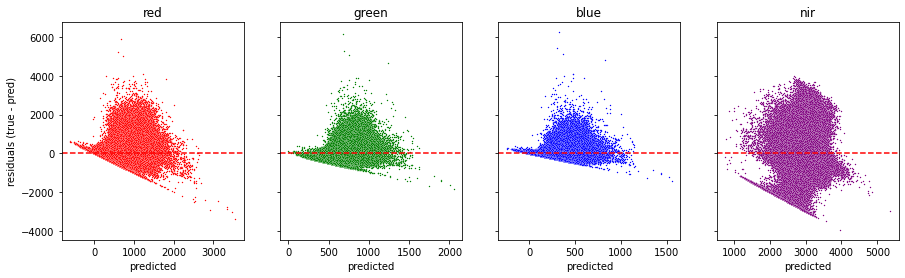

Model: Decision Tree Regressor (Default)


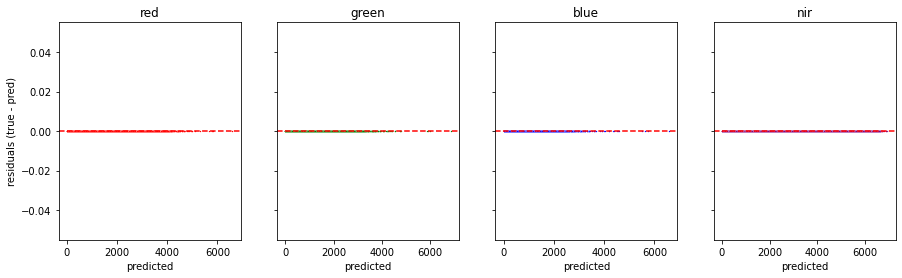

Model: Decision Tree Regressor (Tuned)


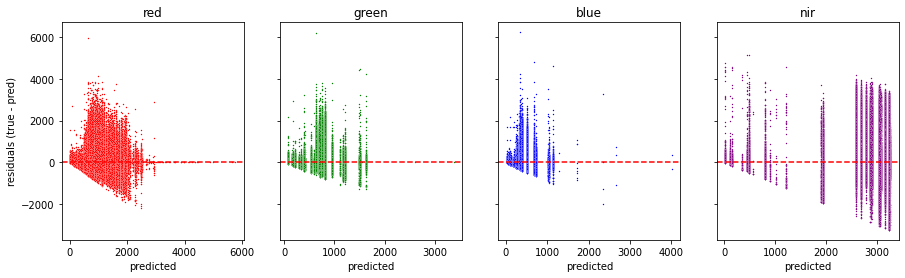

Model: Light Gradient Boosting Regressor (Default)


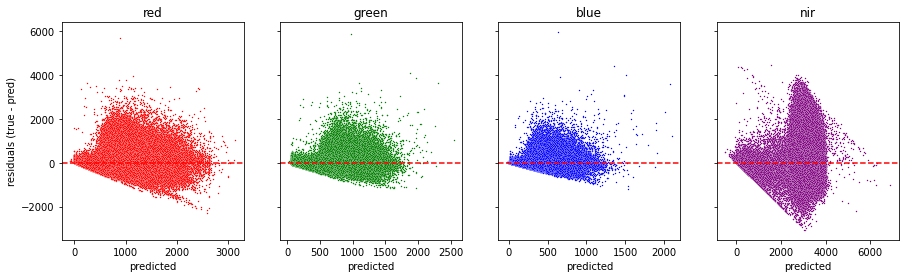

Model: Light Gradient Boosting Regressor (Tuned)


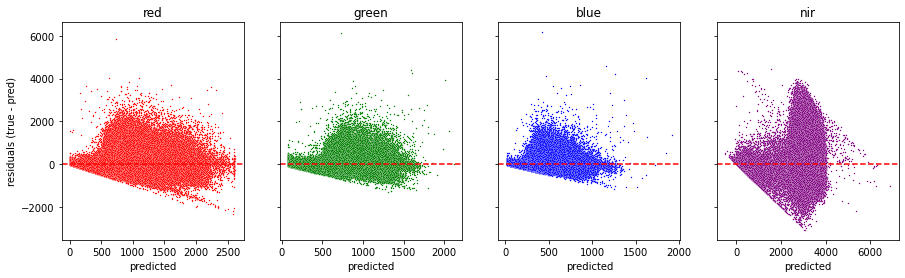

In [67]:
##Load fitted values for one cloud from each model to assess residuals
cloud_select = 0
fitted_files = [np.load(l[cloud_select], allow_pickle = True).tolist() for l in [lin_fitted_files, dt_fitted_files, dt_fitted_tuned_files, lgb_fitted_files, lgb_tuned_fitted_files]]
model_names = ["Linear Regressor", "Decision Tree Regressor (Default)", "Decision Tree Regressor (Tuned)", 
               "Light Gradient Boosting Regressor (Default)", "Light Gradient Boosting Regressor (Tuned)"]

##colors for plotting
plot_colors = ["red", "green", "blue", "purple"]

for i in range(len(fitted_files)):
  print(f'Model: {model_names[i]}')
  residuals_plot(true_data = train_sets[cloud_select], predicted_data = fitted_files[i], sharey = True, figsize = (15,4), size = 2)


##delete for space
del fitted_files


Model: Linear Regressor


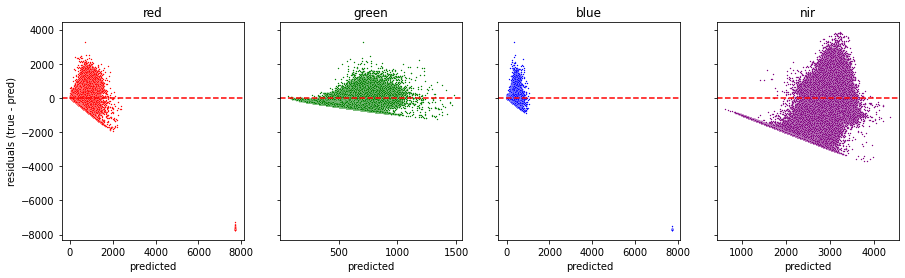

Model: Decision Tree Regressor (Default)


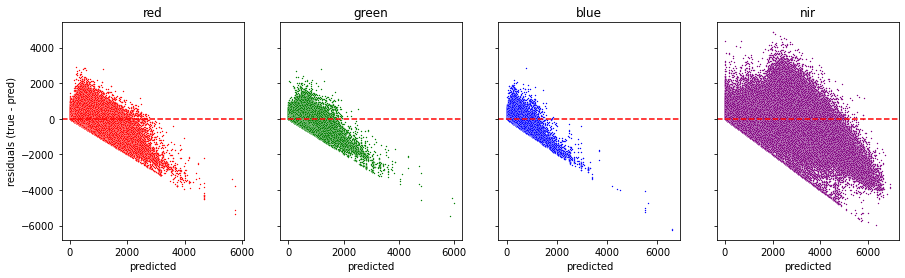

Model: Decision Tree Regressor (Tuned)


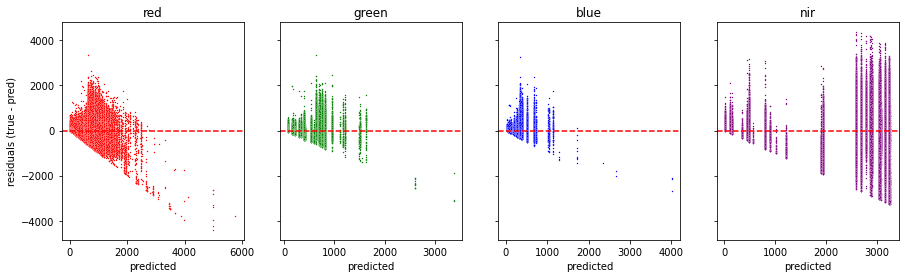

Model: Light Gradient Boosting Regressor (Default)


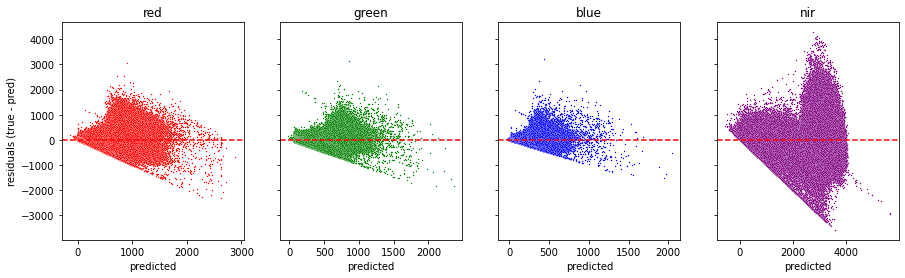

Model: Light Gradient Boosting Regressor (Tuned)


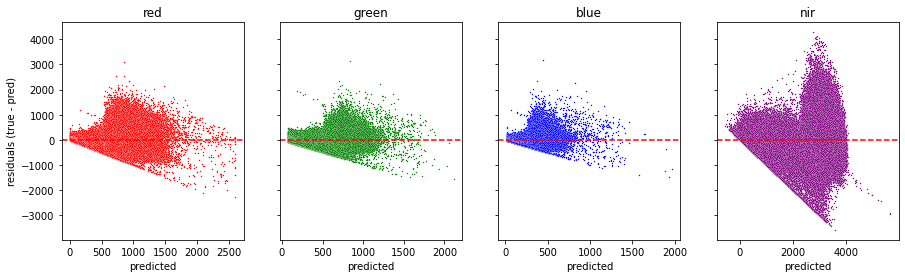

Model: S-CycleGAN


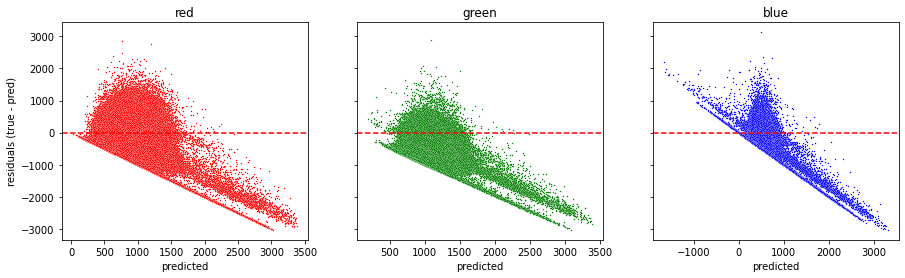

In [79]:
##Load predicted values for one cloud from each model to assess prediction residuals
cloud_select = 0
prediction_file_list = [lin_pred_results_files, dt_pred_results_files, dt_pred_results_tuned_files, 
                        lgb_pred_results_files, lgb_tuned_pred_results_files, gan_pred_results_files]
prediction_files = [np.load(l[cloud_select], allow_pickle = True).tolist() for l in prediction_file_list]

##update model names to include S-CycleGAN
model_names = ["Linear Regressor", "Decision Tree Regressor (Default)", "Decision Tree Regressor (Tuned)", 
               "Light Gradient Boosting Regressor (Default)", "Light Gradient Boosting Regressor (Tuned)", 
               "S-CycleGAN"]

##for saving
outpaths = ["Linear", "DT_default", "DT_tuned", "LGB_default", "LGB_tuned", "scGAN"]

##colors for plotting
plot_colors = ["red", "green", "blue", "purple"]

for i in range(len(prediction_files)):
  print(f'Model: {model_names[i]}')
  save_path = join(output_dir, f"prediction_residuals_{outpaths[i]}.png")
  residuals_plot(true_data = test_sets[cloud_select], predicted_data = prediction_files[i], sharey = True, figsize = (15,4), size = 2, save_path = save_path)




##delete for space
del prediction_file_list, save_path

Model: Linear Regressor
red- RMSE: 524.8140869140625; MAPE: 104.35214233398438
green- RMSE: 297.07159423828125; MAPE: 3.721886396408081
blue- RMSE: 331.9845275878906; MAPE: 25.57255744934082
nir- RMSE: 1222.8319091796875; MAPE: 366.36895751953125
ndvi- RMSE: 0.6681640691527317; MAPE: 390009782253242.0


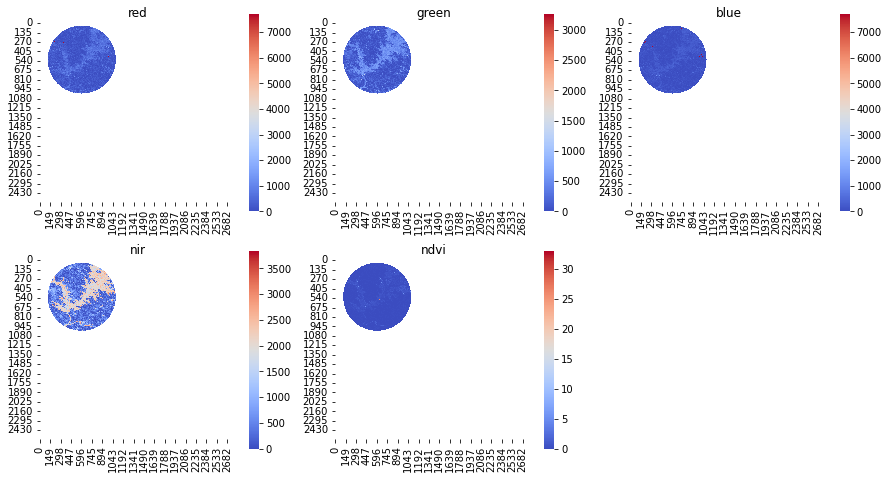

Model: Decision Tree Regressor (Default)
red- RMSE: 370.8096721641184; MAPE: 3.3829112168588455
green- RMSE: 241.89883695726735; MAPE: 0.6572364687124784
blue- RMSE: 190.27242143855156; MAPE: 2.5635391762176076
nir- RMSE: 742.8779843596033; MAPE: 5.381375370846651
ndvi- RMSE: 0.3590766325071567; MAPE: 203607861606574.03


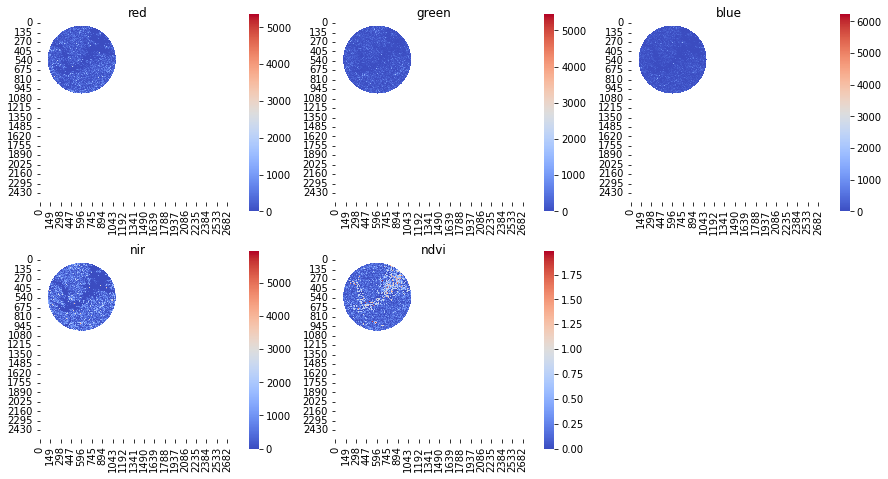

Model: Decision Tree Regressor (Tuned)
red- RMSE: 248.03083078064572; MAPE: 3.598973373548322
green- RMSE: 162.25857013298577; MAPE: 0.62987245346953
blue- RMSE: 124.71950325857287; MAPE: 2.929271072570405
nir- RMSE: 577.0819458066484; MAPE: 15.809275897245348
ndvi- RMSE: 0.2674708164471163; MAPE: 113442940952042.19


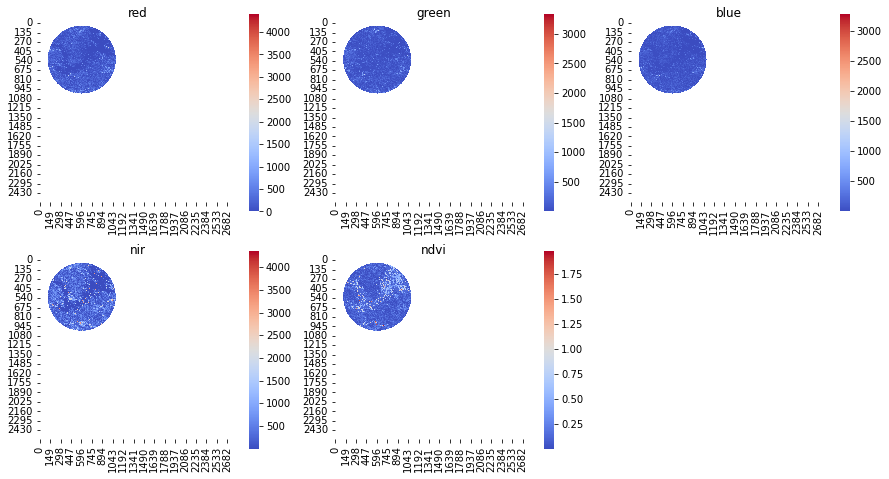

Model: Light Gradient Boosting Regressor (Default)
red- RMSE: 227.07094842676113; MAPE: 2.936290481439255
green- RMSE: 145.82757526307606; MAPE: 0.5136371233098737
blue- RMSE: 114.7344713669526; MAPE: 2.2867861448563658
nir- RMSE: 469.25159993345596; MAPE: 10.451451103683938
ndvi- RMSE: 9.723168458734083; MAPE: 821582551191891.4


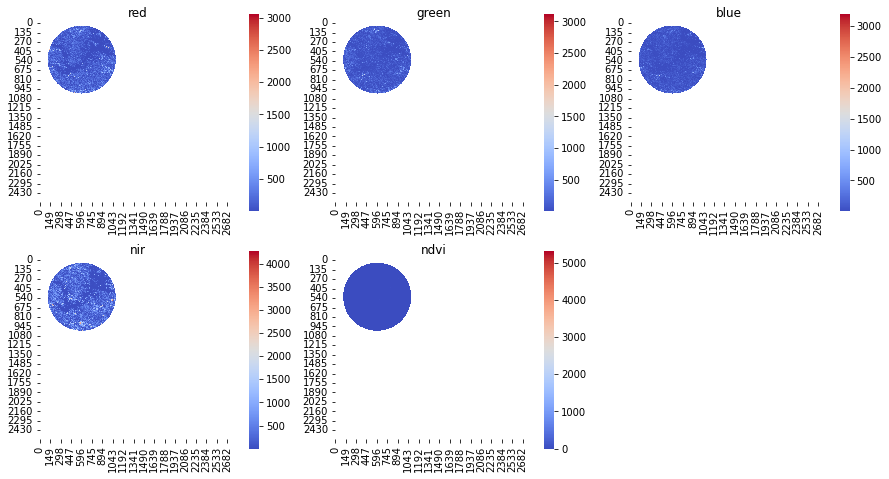

Model: Light Gradient Boosting Regressor (Tuned)
red- RMSE: 227.78410958073184; MAPE: 3.626651173890157
green- RMSE: 146.3619572398827; MAPE: 0.564774086210454
blue- RMSE: 114.95609104702217; MAPE: 2.436089694289204
nir- RMSE: 469.25159993345596; MAPE: 10.451451103683938
ndvi- RMSE: 8.186900274943385; MAPE: 1376380461068630.2


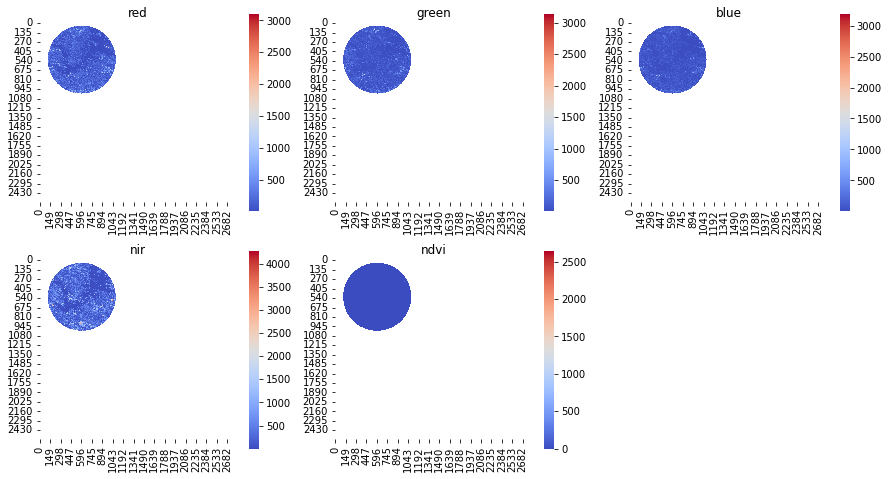

Model: S-CycleGAN
red- RMSE: 576.1904436080557; MAPE: 120.45454674407192
green- RMSE: 671.9061470874526; MAPE: 6.833646322404963
blue- RMSE: 338.073301037279; MAPE: 34.72534179474542


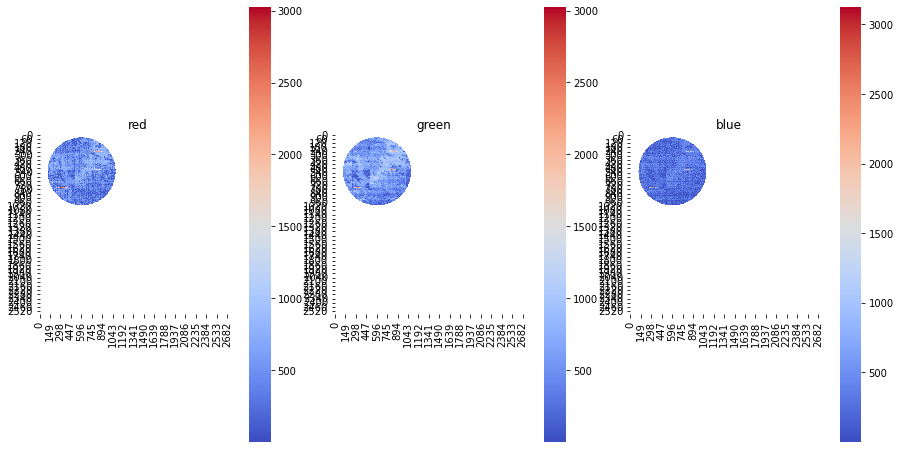

In [58]:
##Plotting Residuals Heatmaps for only one cloud for each model to compare
for i in range(len(prediction_files)):
  print(f'Model: {model_names[i]}')
  heatmap_residuals(true_data = test_sets[cloud_select], predicted_data = prediction_files[i], 
                    cloud_mask = cloud_mask_arrays[cloud_select], figsize = (15,8))
  

Model: Linear Regressor


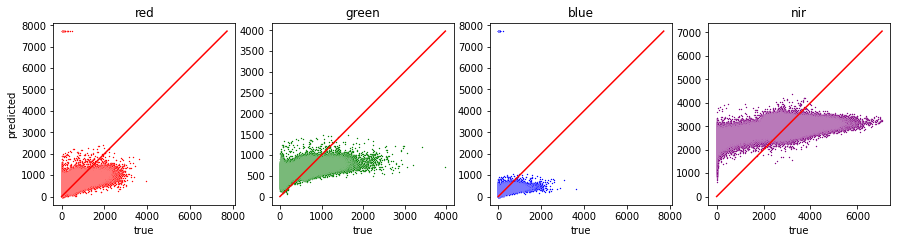

Model: Decision Tree Regressor (Default)


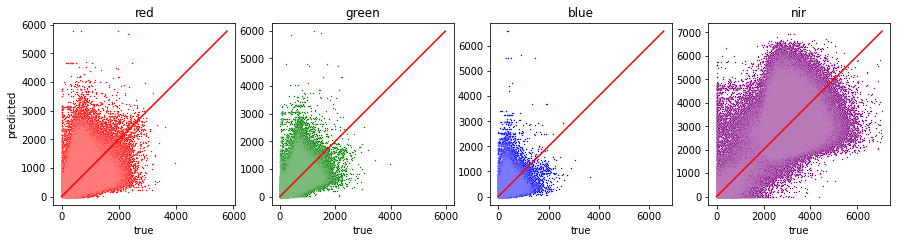

Model: Decision Tree Regressor (Tuned)


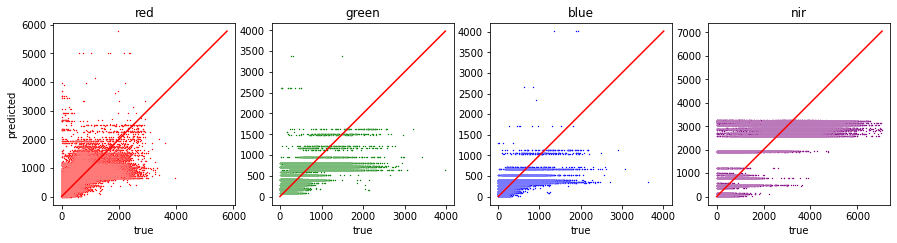

Model: Light Gradient Boosting Regressor (Default)


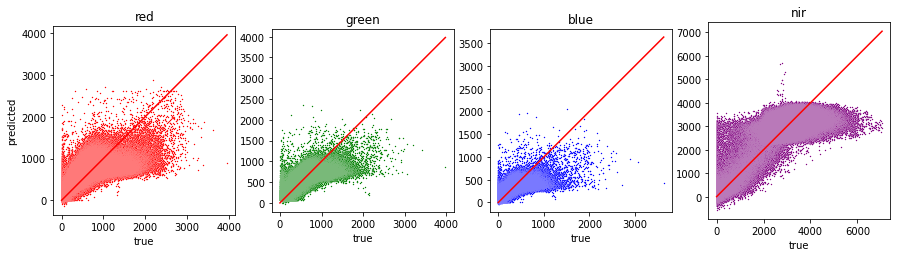

Model: Light Gradient Boosting Regressor (Tuned)


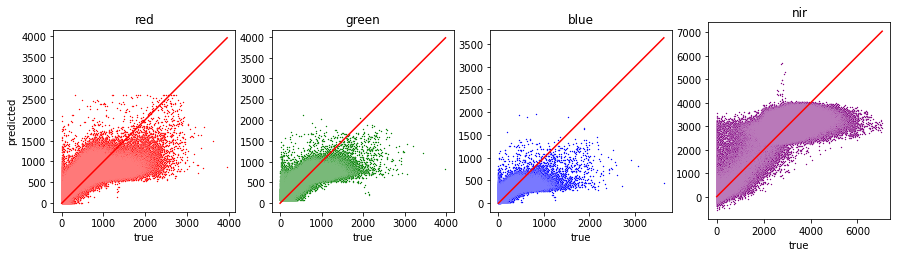

Model: S-CycleGAN


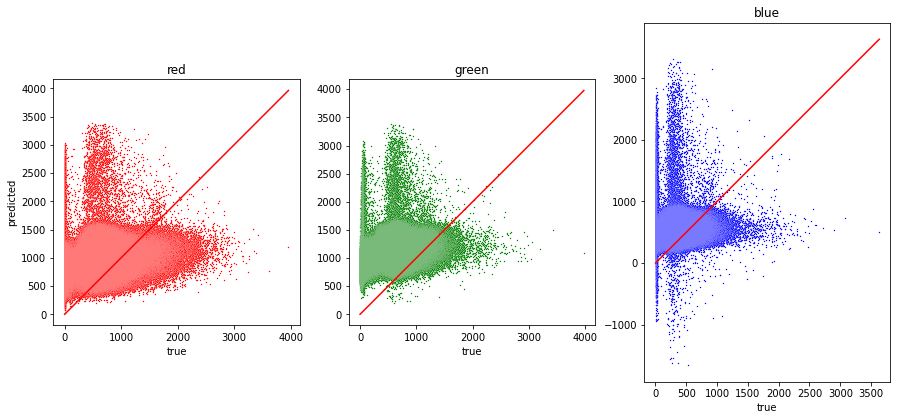

In [82]:
##Select 3 clouds to plot true values against predicted to assess variability
cloud_selects = [0,1,2]
prediction_file_list = [lin_pred_results_files, dt_pred_results_files, dt_pred_results_tuned_files, 
                        lgb_pred_results_files, lgb_tuned_pred_results_files, gan_pred_results_files]
prediction_files = [np.load(l[cloud_selects[0]], allow_pickle = True).tolist() for l in prediction_file_list]
prediction_files2 = [np.load(l[cloud_selects[1]], allow_pickle = True).tolist() for l in prediction_file_list]
prediction_files3 = [np.load(l[cloud_selects[2]], allow_pickle = True).tolist() for l in prediction_file_list]

selected_predictions = [prediction_files]

outpaths = ["Linear", "DT_default", "DT_tuned", "LGB_default", "LGB_tuned", "scGAN"]

##colors for plotting
plot_colors = ["red", "green", "blue", "purple"]

##predicted y-values against true values for three clouds for each model
for i in range(len(prediction_file_list)):
  print(f'Model: {model_names[i]}')

  ##plot the three cloud images for each model
  for j in range(len(selected_predictions)):
    ##Only save the first cloud
    if j == 0:
      save_path = join(output_dir, f"actual_vs_predicted_{outpaths[i]}.png")
    else:
      save_path = None
    plot_fit(true_data = test_sets[cloud_selects[j]], predicted_data = selected_predictions[j][i], 
             sharey = False, figsize = (15,6), alpha = 0.2, size = 2, save_path = save_path)


##delete for memeory
del prediction_file_list, prediction_files, prediction_files2, prediction_files3, cloud_selects, save_path


The results so far suggest that the default decision tree regressor might be the best model. For the actual vs predicted plot, it is the least incorrect. It still overpredicts for small values and underpredicts for large values, but the underpredictions are "smaller" than the rest of the models. It approaches the best one-to-one match. Additionally, it's true vs predicted traces are the most consistent across batches (for the four we viewed). Linear Regression is also consistent, but it is consistently not very good. NIR is bad for all models. Lastly, we didn't show NDVI because we did not create a regression for it. We simply calculated it based on the calculations for the others (the results also showed random predictions with no consistent pattern). Plus, NDVI is more useful in a classification sense, which we will look at later.

In [117]:
gc.collect()

88

Next we will look at the distribution of pixels for the truth vs predicted

Model: Linear Regressor


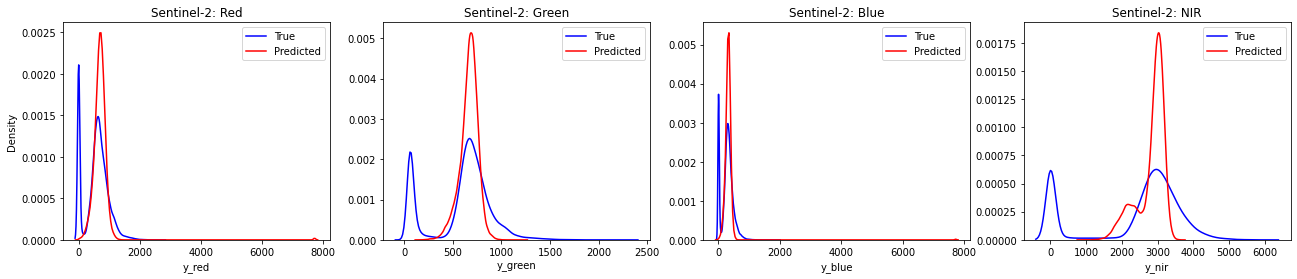

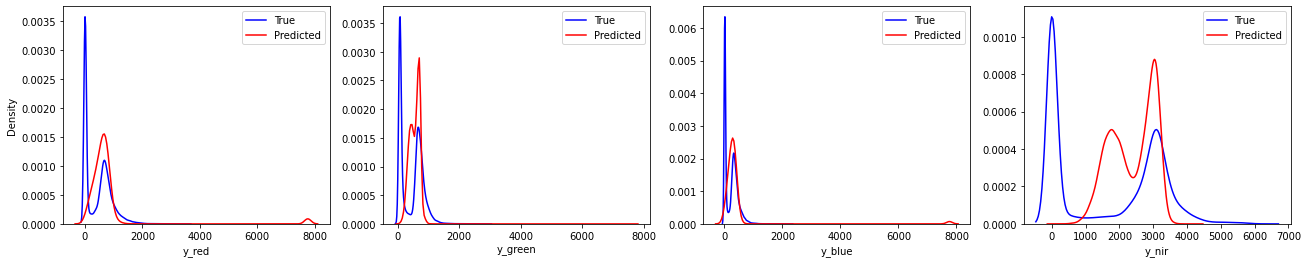

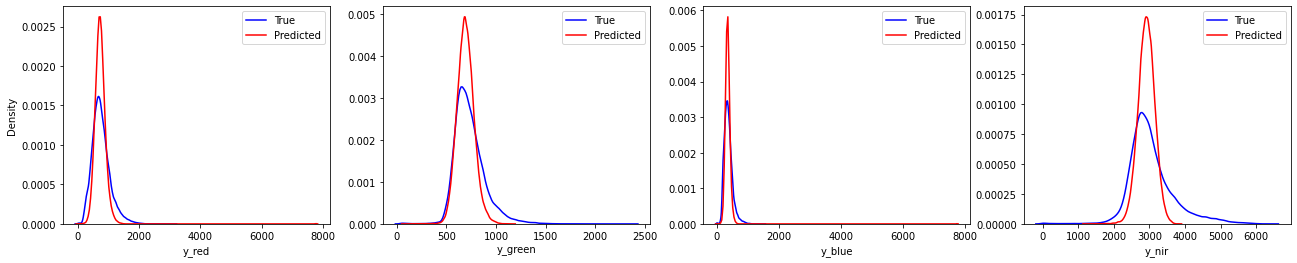

Model: Decision Tree Regressor (Default)


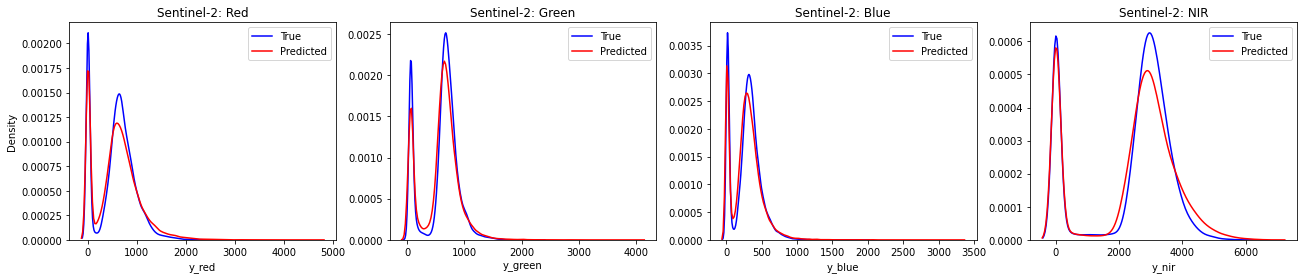

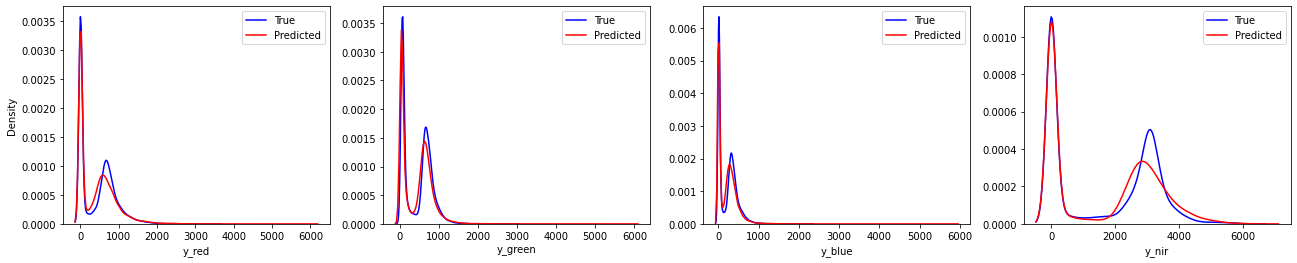

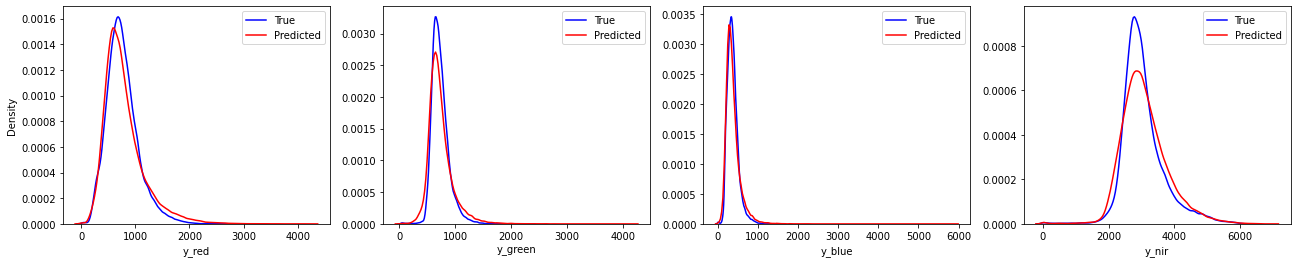

Model: Decision Tree Regressor (Tuned)


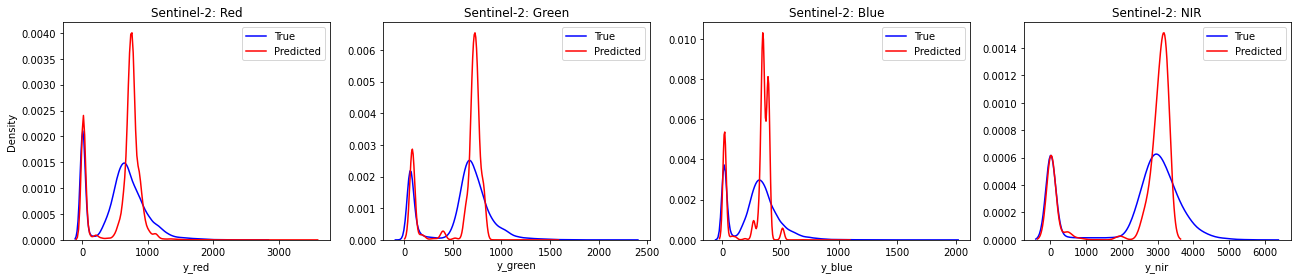

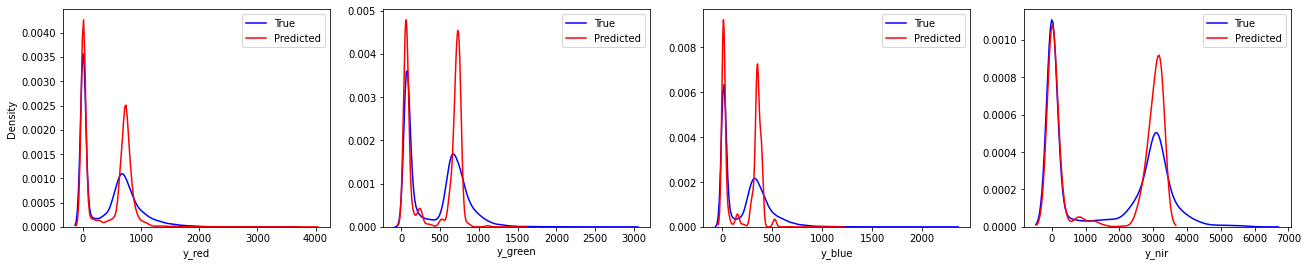

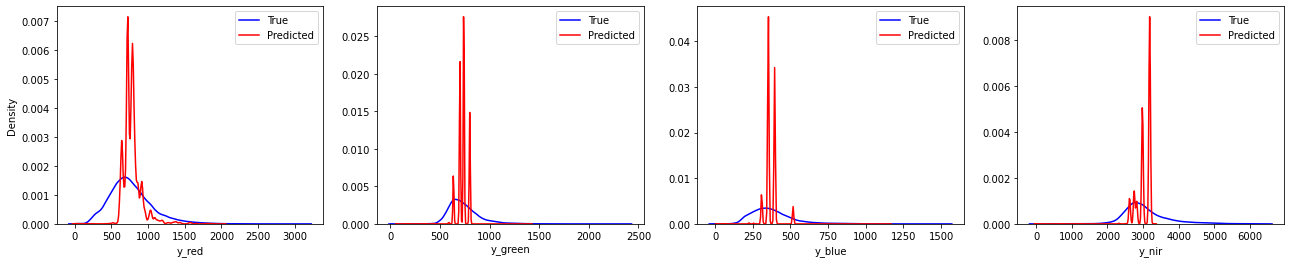

Model: Light Gradient Boosting Regressor (Default)


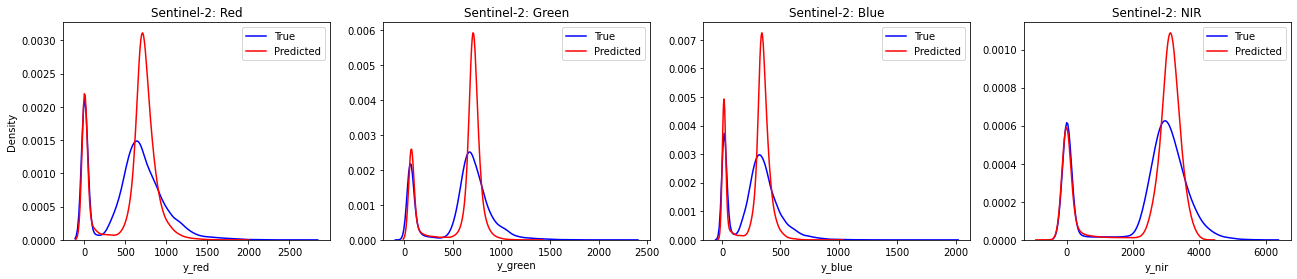

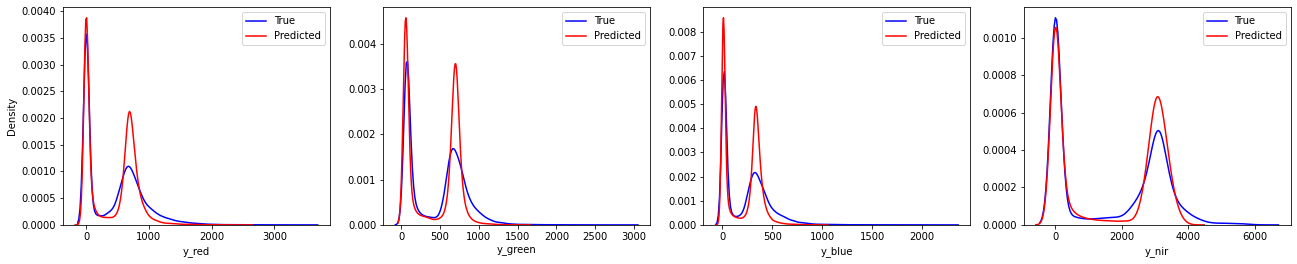

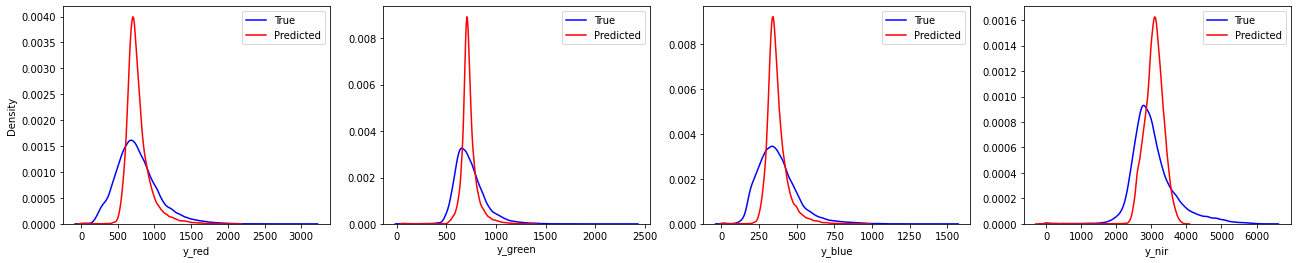

Model: Light Gradient Boosting Regressor (Tuned)


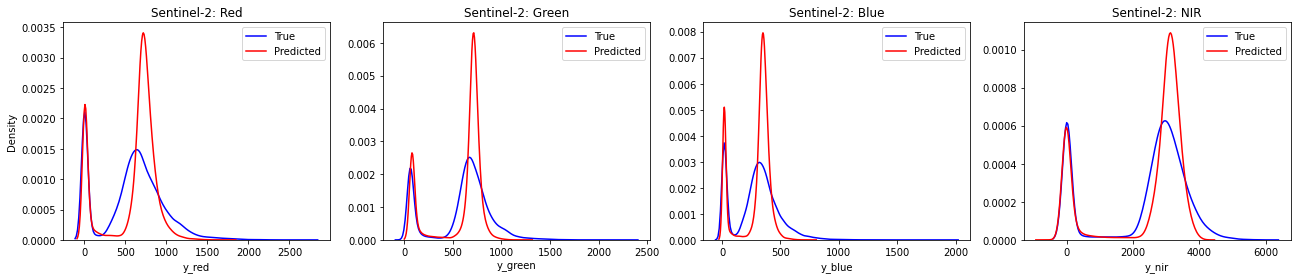

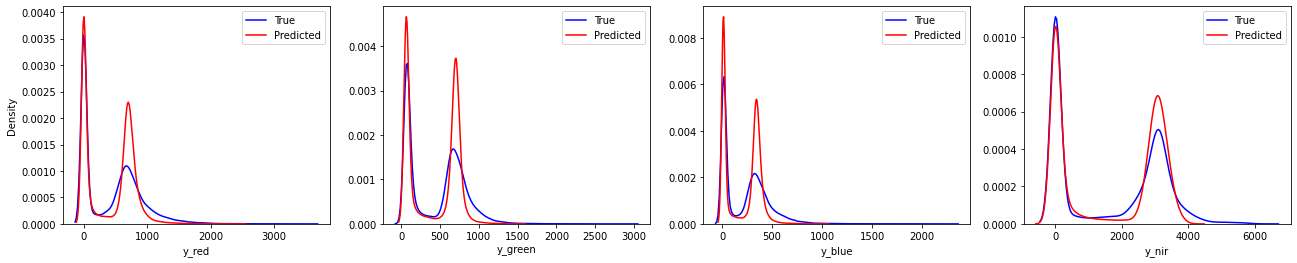

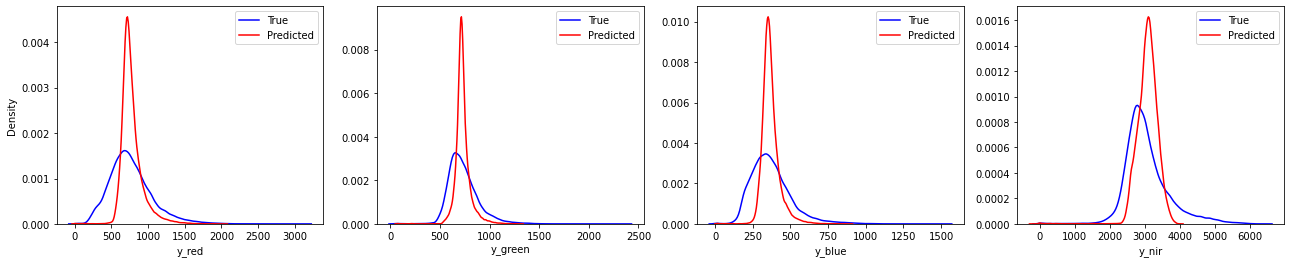

In [87]:
##
##Define integer sampler for consistent sampling
rng = np.random.default_rng(92)
integers = rng.integers

##Plot kdeplots for three cloud images
##ONLY plot first 100,000 (Randomized so it doesn't matter) for memory and computational time
titles = ["Sentinel-2: Red", "Sentinel-2: Green", "Sentinel-2: Blue", "Sentinel-2: NIR"]
plot_n = 100000

##specify sampling indices for test_sets
indices = integers(0, plot_n, plot_n, dtype=np.intp)  # intp is indexing dtype

##Load predictions
cloud_selects = [0,1,2]
prediction_file_list = [lin_pred_results_files, dt_pred_results_files, dt_pred_results_tuned_files, 
                        lgb_pred_results_files, lgb_tuned_pred_results_files]
prediction_files = [np.load(l[cloud_selects[0]], allow_pickle = True).tolist() for l in prediction_file_list]
prediction_files2 = [np.load(l[cloud_selects[1]], allow_pickle = True).tolist() for l in prediction_file_list]
prediction_files3 = [np.load(l[cloud_selects[2]], allow_pickle = True).tolist() for l in prediction_file_list]

selected_predictions = [prediction_files, prediction_files2, prediction_files3]
colors = ["red", "green", "blue", "nir"]

for k in range(len(prediction_file_list)):
  print(f'Model: {model_names[k]}')

  for i in range(len(selected_predictions)):
    fig, ax = plt.subplots(ncols = 4, figsize = (22,4))
    for j in range(4):

      if i == 0:
        sns.kdeplot(data=np.take(test_sets[i], indices, axis = 0).reset_index(), x=y_cols[j], 
                    color = "blue", ax = ax[j], label = "True").set_title(titles[j]) ##actual
        sns.kdeplot(x=selected_predictions[i][k][colors[j]][indices], 
                    color = "red", ax = ax[j], label = "Predicted").set_title(titles[j]) ##predicted
        ax[j].legend()
      else:
        sns.kdeplot(data=np.take(test_sets[i], indices, axis = 0).reset_index(), x=y_cols[j], 
                    color = "blue", ax = ax[j], label = "True")##actual
        sns.kdeplot(x=selected_predictions[i][k][colors[j]][indices], 
                    color = "red", ax = ax[j], label = "Predicted") ##predicted
        ax[j].legend()

        ##remove y_label if not the first
      if j != 0:
        ax[j].set_ylabel(None)

    
    ##Only save the first cloud
    if i == 0:
      plt.savefig(join(output_dir, f"actual_vs_predicted_histogram_{outpaths[k]}.png"))
    plt.show()

  

del prediction_file_list, prediction_files, prediction_files2, prediction_files3, cloud_selects

Next we will summarise the error results across all cloud runs (for each model) to get an idea of the consistency for each model.

##Model Consistency Analysis

In [11]:


##Define a function to calculate statistics for each model in long format and return df

def calc_stats(true_data, predicted_data, colors, y_names, model_name):
  
  ##set up lists for results
  rmse = [None] * len(true_data)
  mape = [None] * len(true_data)

  ##Loop through the get results for each cloud (and color)
  for i in range(len(true_data)):

    ##create lists to store temporary rmse color results
    rmse_col = [None] * len(colors)
    mape_col = [None] * len(colors)

    for j in range(len(colors)):

      ##The data is stored as a dictionary, so we will access by keyes (color and names)
      color = colors[j]
      names = y_names[j]

      ##Check if S-CycleGAN. S-CycleGAN does not have NIR predictions, so we will just set a np.nan value if NIR for S-CycleGAN
      ##We can check by checking if "nir" is a None value, which is how it is specified in the data
      if predicted_data[i]["nir"] is None and (color == "nir" or color == "ndvi"):
        rmse_col[j] = np.nan
        mape_col[j] = np.nan

      ##If Not NIR or NDVI for S-CycleGAN, get MSE and MAPE
      else:

        ##calculating RMSE, and MAPE
        rmse_col[j] = np.sqrt(mean_squared_error(y_true = true_data[i][names], y_pred = predicted_data[i][color]))
        mape_col[j] = mean_absolute_percentage_error(y_true = true_data[i][names], y_pred = predicted_data[i][color])
    
    ##add results to final list
    rmse[i] = rmse_col
    mape[i] = mape_col

    del rmse_col, mape_col

  # ##convert lists to long numpy array (row stack)
  rmse_long = np.concatenate(rmse, axis = 0) ##RMSE for each color in a model stacked for each model
  mape_long = np.concatenate(mape, axis = 0) ##MAPE for each color in a model stacked for each model

  df = pd.DataFrame({"Model": model_name, ##Same Model repeated the whole time
                    "Cloud": np.concatenate([[i+1] * len(colors) for i in range(len(true_data))]), ##cloud repeated length of color and stacked for all models
                    "Color": colors * len(true_data), ##color list repeated length of true data
                    "RMSE": rmse_long, ##RMSE for each color in a model stacked for each model
                    "MAPE": mape_long, ##MAPE for each color in a model stacked for each model
                    })
    
  return df

#########################################################################################################

##Bootstrapping confidence intervals

  
##write function to bootstrap confidence intervals for statistics given all the data in long format
def bootstrap_CI(long_data, stat_var, group_var, alpha, boot_sample, func, func_name, seed):


  ##set seed for reproducibility
  np.random.seed(seed)

  ##Initialize result list
  boot_res = []

  #Loop through for boot_sample (should parallelize this for efficiency)
  for i in range(boot_sample):
    sample_res = long_data.groupby(["Model", group_var]).apply(lambda x: func(x[stat_var].sample(len(x), replace = True)))
    boot_res.append(sample_res)

  ##concatenate results together
  boot_res = pd.concat(boot_res, axis = 1)

  ##get quantiles based on alpha AND mean for results
  q = [(alpha/2), 1-(alpha/2)]

  ##get quantiles and transpose to get into the correct format
  boot_res = boot_res.quantile(q = q, axis = 1).T
  boot_res.columns = [f'{stat_var}_{func_name}_{boot_res.columns[0]}', f'{stat_var}_{func_name}_{boot_res.columns[1]}']

  return boot_res



  


#########################################################################################################



Now we load in the prediction results for each model, calculate the RMSE and MAPE confidence intervals for each, and combine into one dataset for plotting

In [26]:
##Get Long Data for plotting calculating and plotting confidence intervals with sns.pointplot

##define keywords to access the dictionaries
colors = ["red", "green", "blue", "nir", "ndvi"]
y_names = ["y_red", "y_green", "y_blue", "y_nir", "y_ndvi"]

model_names = ["Linear", "Decision Tree (Default)", "Decision Tree (Tuned)", 
               "LGB Regressor (Default)", "LGB Regressor (Tuned)"]

##Get prediction model filenames for loading during loop
prediction_file_list = [lin_pred_results_files, dt_pred_results_files, dt_pred_results_tuned_files, 
                        lgb_pred_results_files, lgb_tuned_pred_results_files]

##Loop over models to add results to a list
model_res_long = [None] * len(model_names) ##initialize results list

for i in range(len(model_names)):
  print(f'Analyzing: {model_names[i]}')

  ##load predicted data for each model (true data is always "test_sets")
  pred_files = prediction_file_list[i]
  predicted_data = [np.load(f, allow_pickle = True).tolist() for f in pred_files] ##load in the dictionaries (for each cloud) as a list

  ##Calculate 95% confidence interval (alpha = 0.05, using t statistic) for each model
  model_res_long[i] = calc_stats(true_data = test_sets, predicted_data = predicted_data,
                            colors = colors, y_names = y_names, model_name = model_names[i])
  
  ##delete loaded data for memory
  del pred_files, predicted_data

##now stack the results together into one dataframe
model_res_long = pd.concat(model_res_long, ignore_index = True)

Analyzing: Linear
Analyzing: Decision Tree (Default)
Analyzing: Decision Tree (Tuned)
Analyzing: LGB Regressor (Default)
Analyzing: LGB Regressor (Tuned)


In [27]:
##create dataframe with confidence intervals (and mean value) for each statistics
boot_sample = 1000
seed = 92

##create data
rmse_means = pd.DataFrame({"RMSE_Mean": model_res_long.groupby(["Model", "Color"]).apply(lambda x: np.mean(x["RMSE"]))}) ##True RMSE Mean of Clouds
rmse_means_CIs = bootstrap_CI(model_res_long, stat_var = "RMSE", group_var = "Color", alpha = 0.05, boot_sample = boot_sample, 
                              func = np.mean, func_name = "Mean", seed = seed) ##Bootstrapped 95% confidence interval for mean

MAPE_means = pd.DataFrame({"MAPE_Mean": model_res_long.groupby(["Model", "Color"]).apply(lambda x: np.mean(x["MAPE"]))})##True MAPE mean of Clouds
MAPE_means_CIs = bootstrap_CI(model_res_long, stat_var = "MAPE", group_var = "Color", alpha = 0.05, boot_sample = boot_sample, 
                              func = np.mean, func_name = "Mean", seed = seed)  ##Bootstrapped 95% confidence interval for cluouds


model_res = pd.concat([rmse_means, rmse_means_CIs, MAPE_means, MAPE_means_CIs], axis = 1)
del rmse_means, rmse_means_CIs, MAPE_means, MAPE_means_CIs


In [29]:
##Make pretty table 

table_headers = ["Model", "Color", "Mean RMSE", "RMSE LB", "RMSE UB", "Mean MAPE", "MAPE LB", "MAPE UB"]
fig = go.Figure(data=[go.Table(
    columnwidth = [2,1],
    header=dict(values=list(table_headers),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=np.round(np.round(model_res, 3).reset_index().T, 3),
               fill_color='lavender',
               align='left',
               format = ["", "", "", "", "", ".3E", ".3E", ".3E"]))
])

fig.show()


<function matplotlib.pyplot.savefig>

Now we will plot the results. We will not look at RMSE and MAPE for NDVI because classification of NDVI values is more useful for land coverage assessment than continuous results. This is done later. 

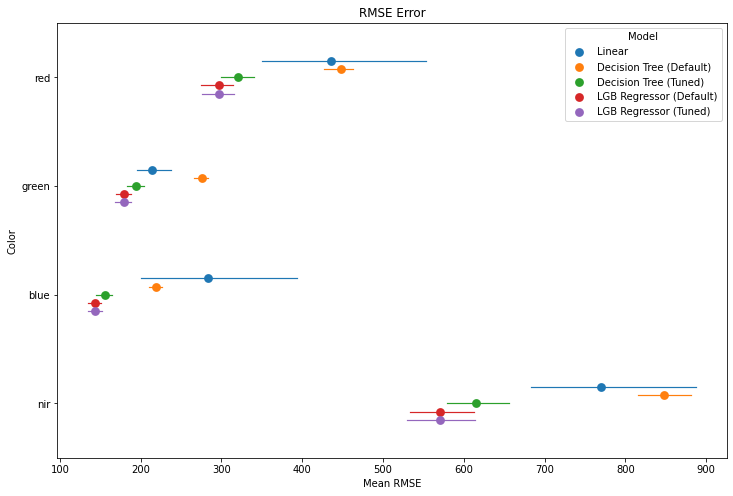

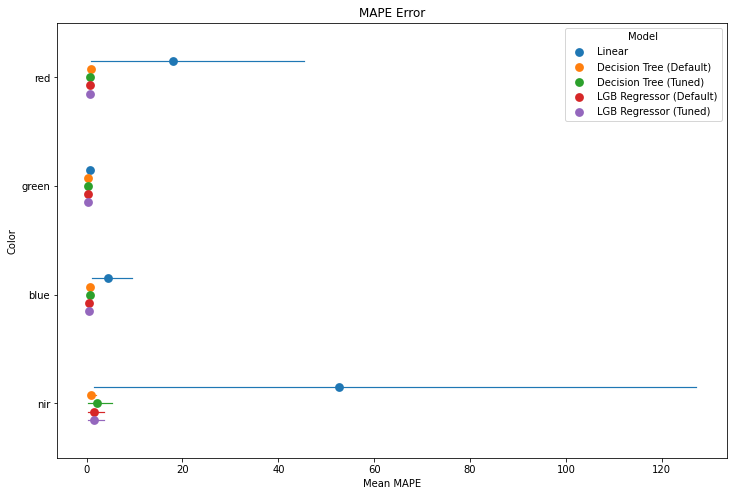

In [58]:
##Plot boostrapped confidence intervals
# fig, ax = plt.subplots(ncols = 2, figsize = (25,8))

##RMSE plot
plt.figure(figsize =(12,8))
sns.pointplot(x = "RMSE", y = "Color", hue = "Model",
              data=model_res_long[model_res_long["Color"] != "ndvi"], dodge=0.3, join=False, 
              errwidth = 1.2, ci=95, random_state = seed).set(title = "RMSE Error", xlabel = "Mean RMSE")
plt.savefig(join(output_dir, "RMSE_CI.png"))
plt.show()

##MAPE plot,
plt.figure(figsize =(12,8))
sns.pointplot(x = "MAPE", y = "Color", hue = "Model",
      data=model_res_long[model_res_long["Color"] != "ndvi"], dodge=0.3, join=False,
      errwidth = 1.2, ci=95, random_state = seed).set(title = "MAPE Error",xlabel = "Mean MAPE")
plt.savefig(join(output_dir, "MAPE_CI.png"))
plt.show()

NDVI can be reported as a continuous variable; however, classification is particularly useful for land coverage assessments. Thus we will assess each model's ability to classify NDVI rather than looking at RMSE and MAPE.
NVDI Classification Results

In [34]:
##write function that gets NVDI classification interval results for each model

def calc_NDVI_CI(true_data, predicted_data, alpha, model_name):


  ##setup list for classification errors
  class_res = [None] * len(true_data)

  for i in range(len(true_data)):

  ##Get NDVI into classes for classification
    true_classes = classify_NDVI(true_data[i]["y_ndvi"])
    pred_classes = classify_NDVI(predicted_data[i]["ndvi"])
    ndvi_class_names = ["No Vegetation","Bare Area","Low\nVegetation","Moderate\nVegetation","High\nVegetation"]

    ##Extract precision, recall, and F1 scores from precision_recall_fscaore_support (they are the first three)
    ##Then transpose so that class is row and statistic is column
    class_res[i] = np.transpose(precision_recall_fscore_support(y_true = true_classes, y_pred = pred_classes)[:3], (1,0)) 

  ##stack along the cloud axis so that simulations are in the third dimension
  class_res_stacked = np.dstack(class_res)

  ##delete for memory
  del class_res, true_classes, pred_classes

  ##calculate statistics
  class_means = class_res_stacked.mean(axis = 2) ##calculate mean of simulations
  class_s = class_res_stacked.std(axis = 2) ##calculate std of simulations
  N_samples = len(true_data) ##get number of samples
  dof = N_samples - 1 ##degrees of freedom
  conf = 1 - alpha ##confidence interval

  ##get t critical value
  t_crit = np.abs(t.ppf((1-conf)/2,dof))

  ##get standard error
  se = class_s*(t_crit/np.sqrt(N_samples))

  ##get conf bounds
  lower_bounds = class_means - se
  upper_bounds = class_means + class_s*(t_crit/np.sqrt(N_samples))

  ##create dataframe
  NDVI_class_res = pd.DataFrame({"Model": model_name, "Class": ndvi_class_names, "N": class_res_stacked.shape[2],
                                "Precision_Mean": class_means[:,0], "Precision_LB": lower_bounds[:,0], "Precision_UB": upper_bounds[:,0], "Precision_SE": se[:,0],
                                "Recall_Mean": class_means[:,1], "Recall_LB": lower_bounds[:,1], "Recall_UB": upper_bounds[:,1], "Recall_SE": se[:,1],
                                "F1_Mean": class_means[:,2], "F1_LB": lower_bounds[:,2], "F1_UB": upper_bounds[:,2], "F1_SE": se[:,2]})
  
  return NDVI_class_res


##Write function to get NDVI classification results in long format

def calc_ndvi_stats(true_data, predicted_data, model_name):
  
  ##setup list for classification errors
  class_res = [None] * len(true_data)
  ndvi_class_names = ["No Vegetation","Bare Area","Low\nVegetation","Moderate\nVegetation","High\nVegetation"] ##class names

  for i in range(len(true_data)):

  ##Get NDVI into classes for classification
    true_classes = classify_NDVI(true_data[i]["y_ndvi"])
    pred_classes = classify_NDVI(predicted_data[i]["ndvi"])
    

    ##Extract precision, recall, and F1 scores from precision_recall_fscore_support (they are the first three)
    ##Then transpose so that class is row and statistic is column
    class_res[i] = np.transpose(precision_recall_fscore_support(y_true = true_classes, y_pred = pred_classes)[:3], (1,0)) 

  ##convert list to long numpy array (row stack)
  class_res_long = np.concatenate(class_res, axis = 0)

  ##create dataframae
  df = pd.DataFrame({"Model": model_name, ##Same Model repeated the whole time
                    "Cloud": np.concatenate([[i+1] * len(ndvi_class_names) for i in range(len(true_data))]), ##cloud repeated length of classes and stacked for all models
                    "Class": ndvi_class_names * len(true_data), ##class list repeated length of true data
                    "Precision": class_res_long[:,0], ##Precision for each class in a model stacked for each model
                    "Recall": class_res_long[:,1], ##Recall for each class in a model stacked for each model
                     "F1": class_res_long[:,2] ##F1 for each class in a model stacked for each model
                    })
    
  return df


Now we load in the prediction results for each model, calculate the NDVI classification error stats for each, and combine into one dataset for plotting. 

In [37]:
##get confidence interval results for NDVI classification stats (Precision, Recall, F1) across all 10 clouds
%%capture

model_names = ["Linear", "Decision Tree (Default)", "Decision Tree (Tuned)", 
               "LGB Regressor (Default)", "LGB Regressor (Tuned)"]

##Get prediction model filenames for loading during loop
prediction_file_list = [lin_pred_results_files, dt_pred_results_files, dt_pred_results_tuned_files, 
                        lgb_pred_results_files, lgb_tuned_pred_results_files]

##Loop over models to add results to a list
NDVI_res_long = [None] * len(model_names) ##initialize results list

for i in range(len(model_names)):

  ##load predicted data for each model (true data is always "test_sets")
  pred_files = prediction_file_list[i]
  predicted_data = [np.load(f, allow_pickle = True).tolist() for f in pred_files] ##load in the dictionaries (for each cloud) as a list

  ##Calculate 95% confidence interval (alpha = 0.05, using t statistic) for each model
  NDVI_res_long[i] = calc_ndvi_stats(true_data = test_sets, predicted_data = predicted_data,
                                     model_name = model_names[i])
  
  ##delete loaded data for memory
  del pred_files, predicted_data

##now stack the results together into one dataframe
NDVI_res_long = pd.concat(NDVI_res_long, ignore_index = True)

In [38]:
display(np.round(NDVI_res_long, 3))

Model  Cloud                 Class  Precision  Recall  \
0                   Linear      1         No Vegetation      0.000   0.000   
1                   Linear      1             Bare Area      0.632   0.004   
2                   Linear      1       Low\nVegetation      0.058   0.014   
3                   Linear      1  Moderate\nVegetation      0.084   0.059   
4                   Linear      1      High\nVegetation      0.747   0.988   
..                     ...    ...                   ...        ...     ...   
245  LGB Regressor (Tuned)     10         No Vegetation      0.580   0.275   
246  LGB Regressor (Tuned)     10             Bare Area      0.093   0.005   
247  LGB Regressor (Tuned)     10       Low\nVegetation      0.557   0.065   
248  LGB Regressor (Tuned)     10  Moderate\nVegetation      0.276   0.065   
249  LGB Regressor (Tuned)     10      High\nVegetation      0.902   0.990   

        F1  
0    0.000  
1    0.009  
2    0.023  
3    0.069  
4    0.850  
..     ...  
245  0.373  
246  0.010  
247  0.117  
248  0.106  
249  0.944  

[250 rows x 6 columns]

In [39]:
##create dataframe with confidence intervals (and mean value) for each statistics
boot_sample = 1000
seed = 92

##create data
prec_means = pd.DataFrame({"Precision_Mean": NDVI_res_long.groupby(["Model", "Class"]).apply(lambda x: np.mean(x["Precision"]))}) ##True Precision Mean of Clouds
prec_means_CIs = bootstrap_CI(NDVI_res_long, stat_var = "Precision", group_var = "Class", alpha = 0.05, boot_sample = boot_sample, 
                              func = np.mean, func_name = "Mean", seed = seed) ##Bootstrapped 95% confidence interval for mean

recall_means = pd.DataFrame({"Recall_Mean": NDVI_res_long.groupby(["Model", "Class"]).apply(lambda x: np.mean(x["Recall"]))})##True Recall mean of Clouds
recall_means_CIs = bootstrap_CI(NDVI_res_long, stat_var = "Recall", group_var = "Class", alpha = 0.05, boot_sample = boot_sample, 
                              func = np.mean, func_name = "Mean", seed = seed)  ##Bootstrapped 95% confidence interval for cluouds

F1_means = pd.DataFrame({"F1_Mean": NDVI_res_long.groupby(["Model", "Class"]).apply(lambda x: np.mean(x["F1"]))})##True Recall mean of Clouds
F1_means_CIs = bootstrap_CI(NDVI_res_long, stat_var = "F1", group_var = "Class", alpha = 0.05, boot_sample = boot_sample, 
                              func = np.mean, func_name = "Mean", seed = seed)  ##Bootstrapped 95% confidence interval for cluouds


NDVI_class_res = pd.concat([prec_means, prec_means_CIs, recall_means, recall_means_CIs, F1_means, F1_means_CIs], axis = 1)
del prec_means, prec_means_CIs, recall_means, recall_means_CIs, F1_means, F1_means_CIs


In [41]:
##Make pretty table 
table_headers = ["Model", "Class", 
                 "Mean Precision", "Precision LB", "Precision UB", 
                 "Mean Recall", "Recall LB", "Recall UB", 
                 "Mean F1", "F1 LB", "F1 UB"]

fig = go.Figure(data=[go.Table(
    columnwidth = [2,2,1],
    header=dict(values=list(table_headers),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=np.round(np.round(NDVI_class_res, 3).reset_index().T, 3),
               fill_color='lavender',
               align='left',
               format = ["", ""]))
])

fig.show()

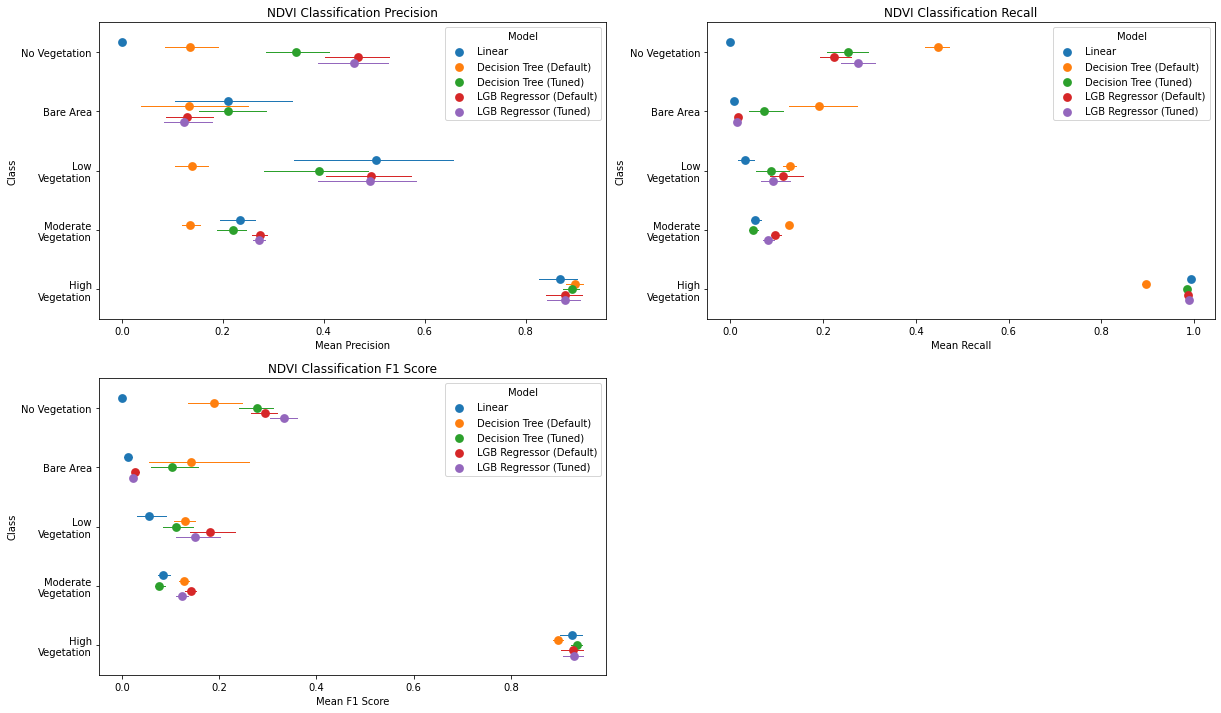

In [48]:
##Plot boostrapped confidence intervals
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20,12))

##Precision plot
sns.pointplot(x = "Precision", y = "Class", hue = "Model",
              data=NDVI_res_long, dodge=0.35, join=False, errwidth = 1, 
              ci=95, ax = ax[0,0], random_state = seed)
ax[0,0].set(title = "NDVI Classification Precision",
          xlabel = "Mean Precision")

##Recall plot
sns.pointplot(x = "Recall", y = "Class", hue = "Model",
      data = NDVI_res_long, dodge=0.35, join=False, errwidth = 1,
      ci=95, ax = ax[0,1], random_state = seed)
ax[0,1].set(title = "NDVI Classification Recall",
          xlabel = "Mean Recall")

##F1 plot
sns.pointplot(x = "F1", y = "Class", hue = "Model",
      data=NDVI_res_long, dodge=0.35, join=False, errwidth = 1,
      ci=95, ax = ax[1,0], random_state = seed)
ax[1,0].set(title = "NDVI Classification F1 Score",
          xlabel = "Mean F1 Score")

##delete the sixth subplot, since we don't use it
fig.delaxes(ax[1, 1])


In [181]:
gc.collect()

421

##Visualize Predicted Images

Now that we have summary statistics, we will visualize the actual images (RGB, NIR-shifted, and NDVI). To do this, we will build a function that plots ground truth along with all predicted images (for each cloud) for a given model.

In [49]:
##write function to plot original image, cloudy image, and predicted image
def plot_images(original_raster, cloudy_raster_list, predicted_list, rgba_order, color_plot_order, figsize, NDVI = False):

  ##process original image outside of loop so we only process once
  ##first read the raster, then reorder the dims so it is (wid, height, channel)
  ##then subset the colors to plot, then normalize to 0-1 for plottin

  if NDVI == False:
    original = normalize(np.transpose(original_raster.read(rgba_order), (1,2,0))[:,:,color_plot_order])
  else:
    original = np.transpose(original_raster.read(rgba_order), (1,2,0)) ##gets all bands without normalizing
    original_NDVI = (original[:,:,3]-original[:,:,0])/(original[:,:,3] + original[:,:,0]) ##calculates NVDI 


  ##Plot images in same plot
  n_images = len(predicted_list)
  fig, ax = plt.subplots(nrows = 2, ncols = n_images + 1, figsize = figsize, squeeze = False)

  ##Plotting round truth in the first column every time
  if NDVI == False:
    ax[0,0].imshow(original) ##plot original as ground truth in first col
    ax[1,0].imshow(original) ##plot original as ground truth in first col

  else: ##NDVI image
    ax[0,0].imshow(original_NDVI, cmap = "RdYlGn", vmin = -1, vmax = 1) ##plot original as ground truth in first row
    ax[1,0].imshow(original_NDVI, cmap = "RdYlGn", vmin = -1, vmax = 1) ##plot original as ground truth in first row

  ##first row will be all ground truth, second will be al cloudy images
  ##and third will be all predicted images
  ##read and manipulate in the loop and then delete for memory purposes
  for i in range(n_images):

    ##read rasters to numpy arrays and rearrange so that colors are in RGBA order
    ##and dimensions are in (width, height, channel) format
    ##Then subset the plot into 3 channels based on color_plot_order and normalize for plotting
    if NDVI == False:
      cloudy_image = normalize(np.transpose(cloudy_raster_list[i].read(rgba_order), (1,2,0))[:,:,color_plot_order])
      predicted_image = normalize(predicted_list[i][:,:,color_plot_order])

      ##plot images
      ax[0,i+1].imshow(cloudy_image) ##plot cloudy as reference in second row
      ax[1,i+1].imshow(predicted_image) ##plot predicted in third row

      ##delete for ram
      del cloudy_image, predicted_image

    else: ##if plotting nvdi
      cloudy_image = np.transpose(cloudy_raster_list[i].read(rgba_order), (1,2,0)) ##gets all bands without normalizing
      predicted_image = predicted_list[i] ##gets all bands without normalizing
      
      ##Calculate NDVI
      cloud_NDVI = (cloudy_image[:,:,3]-cloudy_image[:,:,0])/(cloudy_image[:,:,3] + cloudy_image[:,:,0]) ##calculates NVDI 
      predicted_NDVI = predicted_image[:,:,4] ##pulls NVDI from the predicted image calculations (5th channel)

      ##plot images
      ##NDVI ranges from -1 to 1 so we need to set the vmin and vmax
      ax[0,i+1].imshow(cloud_NDVI, cmap = "RdYlGn", vmin = -1, vmax = 1) ##plot cloudy as reference in second row
      ax[1,i+1].imshow(predicted_NDVI, cmap = "RdYlGn", vmin = -1, vmax = 1) ##plot predicted in third row

      ##delete for ram
      del cloudy_image, predicted_image, cloud_NDVI, predicted_NDVI


    ##get rid of axis tikcs
    ##x ticks
    ax[0,i].set_xticks([])
    ax[1,i].set_xticks([])
    # ax[2,i].set_xticks([])

    ##y_ticks
    ax[0,i].set_yticks([])
    ax[1,i].set_yticks([])
    # ax[2,i].set_yticks([])

  ##delete for RAM
  del original

  ##set titles
  colnames = ["Ground Truth"] + [f'Cloud {col}' for col in range(1, n_images + 1)]
  rownames = ["Cloudy\nImages", "Clouds\nPredicted"]

  for i in range(n_images + 1):
    ax[0,i].set_title(colnames[i])

  for i in range(2):
    ax[i,0].set_ylabel(rownames[i], rotation=90, size='large', labelpad = 8)

  ##collect and remove unused objects for RAM
  gc.collect()
  fig.tight_layout() 
  plt.show()

#############################################################################################

##Write function that will plot ground truth along with predicted images for any model

def plot_images2(original_raster_filename, predicted_filename_list, raster_rgba_order, color_plot_order, 
                   figsize, y_label, process_cloud=False, set_title = False, NDVI = False, save = False, save_path = None):

  """
  Inputs:
  original_raster_filename: filename of ground truth image
  predicted_filename_list: list of filenames containing images reconstructed from model predictions
  raster_rgba_order: The order of R,G,B,NIR in the raster image (predicted images are always R,G,B,NIR,NDVI)
  color_plot_order: Order to plot the colors in (for either RGB, NIR shifted, or NDVI)
  figsize: figsize of each image
  y_label: Name of the y-axis (ie which model or cloud)
  process_cloud: Whether predicted_filename_list contains filenames for cloud rasters or not
  set_title: Whether to name the subplots (Only the first row in the final plot should be labeled, so we have to specify to label it)
  NDVI: Whether to plot NDVI images (and calculate NDVI for raster) or not (Boolean)
  save: Whether to save the image or not (Boolean)
  save_path: Path to save the image if save == True

  Output: matplot subplot with one row and 11 columns containing ground truth, cloud1 reconstruction, ..., cloud10 reconstruction
  
  """

  ##setup plot
  ncols = len(predicted_filename_list) + 1 ##total predicted images + ground truth
  fig, ax = plt.subplots(ncols = ncols, figsize = figsize, squeeze = True) ##set squeeze to true so we can add to another subplot later

  ##Original image will always go in the first ocol and it is processed diffferently so it will go outside the loop

  ##read in raster object
  original_raster = rio.open(original_raster_filename) 

  ##If not plotting NDVI image
  if NDVI == False:
    ##Read numpy array in rgba_order, transpose so dimensions are (width, height, channel), 
    ##select channels for plotting, and normalize to 0-1 for plotting
    original = normalize(np.transpose(original_raster.read(raster_rgba_order), (1,2,0))[:,:,color_plot_order]) 

    ##add original to the plot and remove to save memory
    ax[0].imshow(original) ##plot original
    ax[0].set_xticks([]) ##remove x ticks
    ax[0].set_yticks([])  ##remove y ticks
    del original, original_raster

  ##If plotting NDVI image
  else:
    ##Read numpy arrays in rgba_order without normalizing and then calculate NDVI
    ##NDVI is a normalized value, so no need to normalize (we will set min max to -1 and 1 though for NDVI)
    original = np.transpose(original_raster.read(raster_rgba_order), (1,2,0)) ##gets all bands without normalizing
    original_NDVI = (original[:,:,3]-original[:,:,0])/(original[:,:,3] + original[:,:,0]) ##calculates NVDI 

    ##add original to the plot and specify max/min values for NDVI scale (then remove to sae memory)
    ax[0].imshow(original_NDVI, cmap = "RdYlGn", vmin = -1, vmax = 1) ##plot original as ground truth in first row
    del original, original_NDVI, original_raster
  
  ##Now setup loop to process the remaining images and add them to the subplot object
  ##We process during the loop to reduce the amount of memory used at once then remove the object
  n_images = len(predicted_filename_list)

  ##loop thrugh all predicted images to load, process, and add to graph
  for i in range(n_images):

    ##if not processing NDVI and working with a predicted image
    if NDVI == False and process_cloud == False:

      ##load image, select colors to plot, normalize to 0-1 for plotting, then plot
      predicted_image = normalize(np.load(predicted_filename_list[i])[:,:,color_plot_order])
      ax[i + 1].imshow(predicted_image)

      ##delete for ram
      del predicted_image

    ##if processing for NDVI and working with a predicted image
    elif NDVI == True and process_cloud == False:

      ##Load image, select NDVI predicted channel (fifth channel, index: 4), and plot
      predicted_NDVI = np.load(predicted_filename_list[i])[:,:,4] ##loads and selects NDVI channel
      ax[i+1].imshow(predicted_NDVI, cmap = "RdYlGn", vmin = -1, vmax = 1) ##plot predicted in third row

      ##remove for ram
      del predicted_NDVI

    ##if not processing NDVI and working with a cloud raster image
    elif NDVI == False and process_cloud == True:

      ##load image, select colors to plot, normalize to 0-1 for plotting, then plot
      cloud_raster = rio.open(predicted_filename_list[i])
      cloud_image = normalize(np.transpose(cloud_raster.read(raster_rgba_order), (1,2,0))[:,:,color_plot_order]) 
      ax[i + 1].imshow(cloud_image)

      ##delete for ram
      del cloud_raster, cloud_image

    ##If processing NDVI and working with a cloud raster image
    else:
      ##Read numpy arrays in rgba_order without normalizing and then calculate NDVI
      ##NDVI is a normalized value, so no need to normalize (we will set min max to -1 and 1 though for NDVI)
      cloud_raster = rio.open(predicted_filename_list[i])
      cloud_image = np.transpose(cloud_raster.read(raster_rgba_order), (1,2,0)) ##gets all bands without normalizing
      cloud_NDVI = (cloud_image[:,:,3]-cloud_image[:,:,0])/(cloud_image[:,:,3] + cloud_image[:,:,0]) ##calculates NVDI 

      ##add to the plot and specify max/min values for NDVI scale (then remove to sae memory)
      ax[i + 1].imshow(cloud_NDVI, cmap = "RdYlGn", vmin = -1, vmax = 1) ##plot original as ground truth in first row
      del cloud_raster, cloud_image, cloud_NDVI


    ##get rid of axis ticks
    ax[i+1].set_xticks([]) ##x ticks
    ax[i+1].set_yticks([]) ##y ticks

  ##set y_label (Model name)
  ax[0].set_ylabel(y_label, rotation = 90, size = 'large', labelpad = 8)

  ##set column titles if specified
  if set_title == True:
    colnames = ["Ground Truth"] + [f'Cloud {col}' for col in range(1, n_images + 1)]

    for i in range(ncols):
      ax[i].set_title(colnames[i])

  ##collect and remove unused objects for RAM
  gc.collect()

  ##Set tight layout and (save) show plot
  fig.tight_layout() 
  if save == True: plt.savefig(save_path) # To save figure
  plt.show()

#################################################################################################################









In [50]:
##Get predicted image filenames
lin_pred_image_files = [join(pred_results_dir, f) for f in natsorted(os.listdir(pred_results_dir)) if bool(re.search("cloud.*npy", f))]
dt_pred_image_files = [join(dt_pred_results_dir, f) for f in natsorted(os.listdir(dt_pred_results_dir)) if bool(re.search("cloud.*npy", f))]
dt_pred_image_tuned_files = [join(dt_tuned_pred_results_dir, f) for f in natsorted(os.listdir(dt_tuned_pred_results_dir)) if bool(re.search("cloud.*npy", f))]
lgb_pred_image_files = [join(lgb_pred_results_dir, f) for f in natsorted(os.listdir(lgb_pred_results_dir)) if bool(re.search("cloud.*npy", f))]
lgb_tuned_pred_image_files = [join(lgb_tuned_pred_results_dir, f) for f in natsorted(os.listdir(lgb_tuned_pred_results_dir)) if bool(re.search("cloud.*npy", f))]
gan_pred_image_files = [join(gan_pred_results_dir, f) for f in natsorted(os.listdir(gan_pred_results_dir)) if bool(re.search("cloud.*npy", f))]

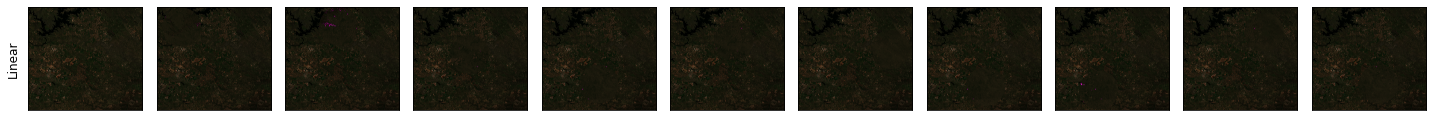

In [51]:
##Plot cloudy reference images with the predicted (filled) images for each model

##Set up variables needed for plotting
original_raster_filename = sen2_images[choose_ind]
prediction_file_list = [lin_pred_image_files, dt_pred_image_files, dt_pred_image_tuned_files, lgb_pred_image_files, lgb_tuned_pred_image_files, gan_pred_image_files]
model_names = ["Linear", "Decision Tree\n(Default)", "Decision Tree\n(Tuned)", 
               "LGB Regressor\n(Default)", "LGB Regressor\n(Tuned)", "S-CycleGAN"]
raster_rgba_order = [3,2,1,4]
color_order = [0,1,2]
shifted_order = [3,0,1]

i = 0

plot_images2(original_raster_filename=original_raster_filename, predicted_filename_list = prediction_file_list[i], 
               raster_rgba_order = raster_rgba_order, color_plot_order = color_order, figsize = (20,15), y_label = model_names[i],
               process_cloud = False, set_title = False, NDVI = False, save = False, save_path = None)

In [ ]:
gc.collect()


16614

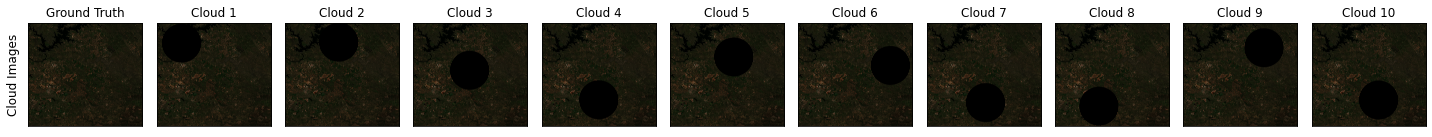

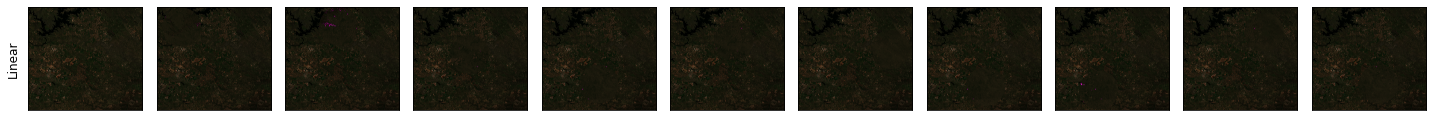

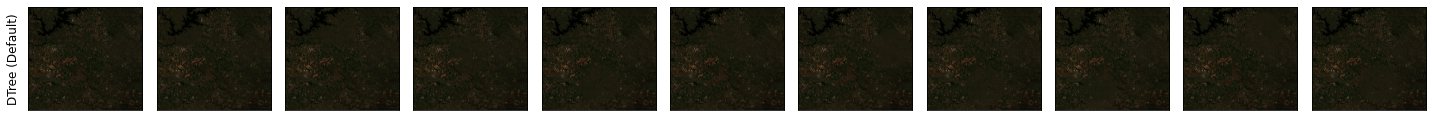

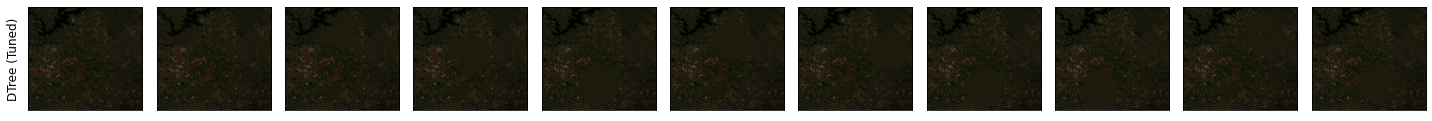

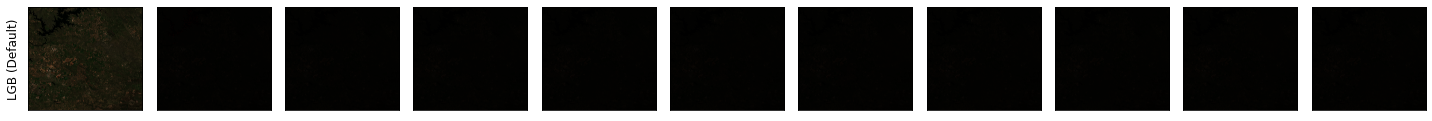

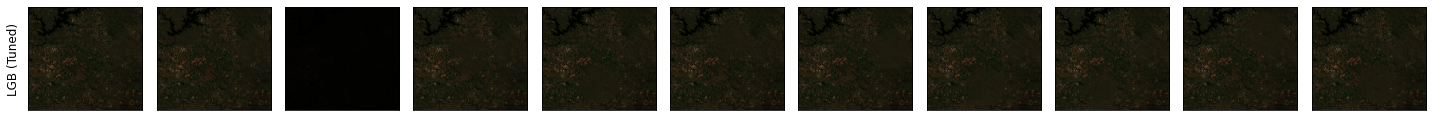

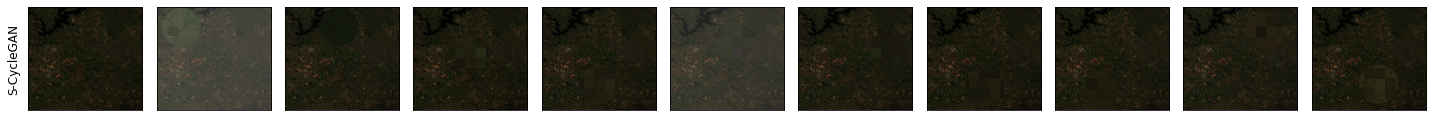

In [52]:
##Plot cloudy reference images with the predicted (filled) images for each model

##make outputfiles
save_names = [f"Cloud_Images_aoi_{choose_ind}.png", f"Linear_Pred_aoi_{choose_ind}.png", f"DTree_Pred_aoi_{choose_ind}.png", f"DTree_Tuned_Pred_aoi_{choose_ind}.png",
              f"LGB_Pred_aoi_{choose_ind}.png",f"LGB_Tuned_Pred_aoi_{choose_ind}.png", f"GAN_Pred_aoi_{choose_ind}.png"]
save_paths = [join(output_dir, f) for f in save_names]


##Set up variables needed for plotting
original_raster_filename = sen2_images[choose_ind]
cloud_file_list = sen2_cloud_im[choose_ind] ##get cloud filenames for the chosen index
prediction_file_list = [cloud_file_list, lin_pred_image_files, dt_pred_image_files, dt_pred_image_tuned_files, 
                        lgb_pred_image_files, lgb_tuned_pred_image_files, gan_pred_image_files] ##list of all filenames
titles = ["Cloud Images", "Linear", "DTree (Default)", "DTree (Tuned)", 
          "LGB (Default)", "LGB (Tuned)", "S-CycleGAN"] ##titles for plotting
raster_rgba_order = [3,2,1,4] ##raster R,G,B,NIR order
color_order = [0,1,2] ##color order for plotting
shifted_order = [3,0,1] ##shifted color order for NIR shift


##Loop through to plot clouds + models
for i in range(len(titles)):

  if i == 0:
    process_cloud = True; set_title = True
  else:
    process_cloud = False; set_title = False

  plot_images2(original_raster_filename=original_raster_filename, predicted_filename_list = prediction_file_list[i], 
                raster_rgba_order = raster_rgba_order, color_plot_order = color_order, figsize = (20,15), y_label = titles[i],
                process_cloud = process_cloud, set_title = set_title, NDVI = False, save = True, save_path = save_paths[i])
  
  del process_cloud, set_title

In [195]:
gc.collect()


17339

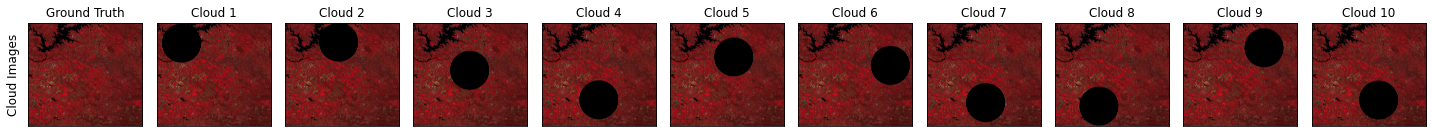

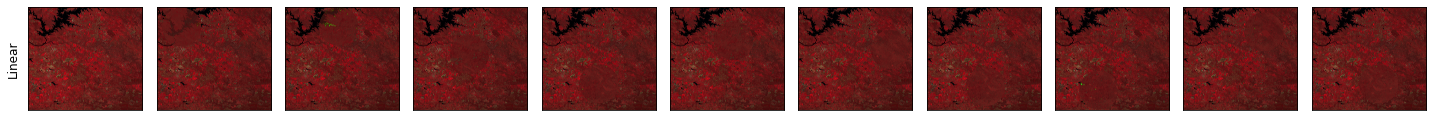

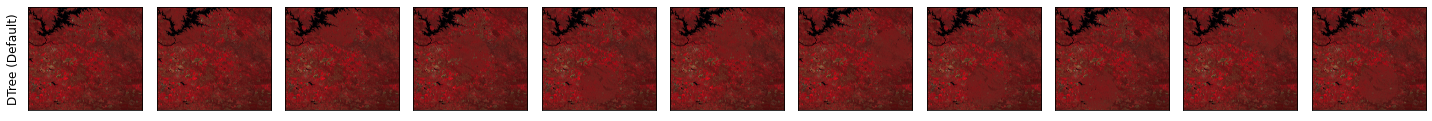

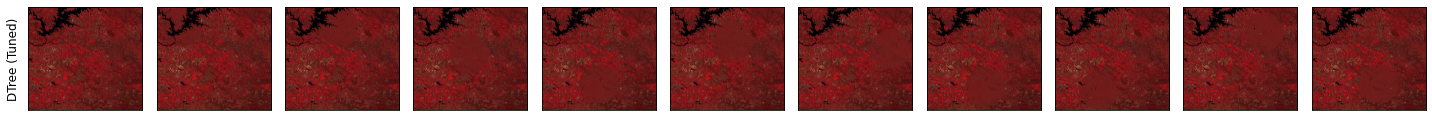

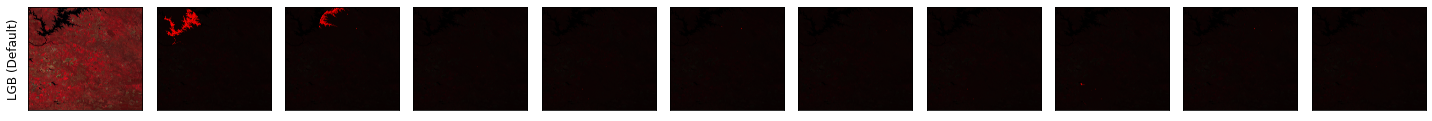

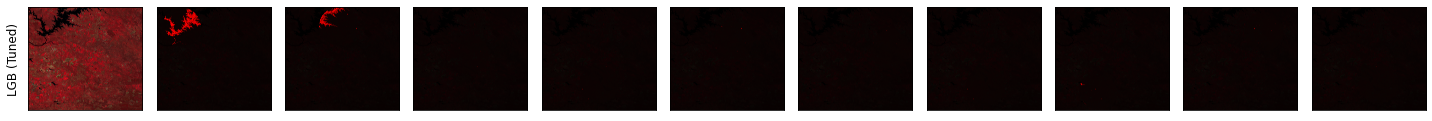

In [59]:
##Plot shifted NIR images

##make outputfiles
save_names = [f"Cloud_Images_NIR_aoi_{choose_ind}.png", f"Linear_Pred_NIR_aoi_{choose_ind}.png", f"DTree_Pred_NIR_aoi_{choose_ind}.png", 
              f"DTree_Tuned_Pred_NIR_aoi_{choose_ind}.png",
              f"LGB_Pred_NIR_aoi_{choose_ind}.png",f"LGB_Tuned_Pred_NIR_aoi_{choose_ind}.png"]
save_paths = [join(output_dir, f) for f in save_names]


##File List, Model Names, and Title without S-CycleGAN because S-CycleGAN cannot produce NIR
prediction_file_list = [cloud_file_list, lin_pred_image_files, dt_pred_image_files, dt_pred_image_tuned_files, 
                        lgb_pred_image_files, lgb_tuned_pred_image_files]
model_names = ["Linear", "Decision Tree\n(Default)", "Decision Tree\n(Tuned)", 
               "LGB Regressor\n(Default)", "LGB Regressor\n(Tuned)"]
titles = ["Cloud Images", "Linear", "DTree (Default)", "DTree (Tuned)", 
          "LGB (Default)", "LGB (Tuned)"] ##titles for plotting

##Loop through to plot clouds + models
for i in range(len(titles)):

  if i == 0:
    process_cloud = True; set_title = True
  else:
    process_cloud = False; set_title = False

  plot_images2(original_raster_filename=original_raster_filename, predicted_filename_list = prediction_file_list[i], 
                raster_rgba_order = raster_rgba_order, color_plot_order = shifted_order, figsize = (20,15), y_label = titles[i],
                process_cloud = process_cloud, set_title = set_title, NDVI = False, save = True, save_path = save_paths[i])
  
  del process_cloud, set_title

In [194]:
shifted_order

[3, 0, 1]

In [ ]:
gc.collect()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in true_divide


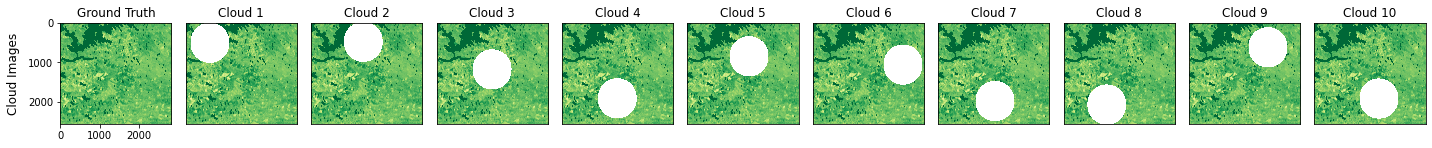

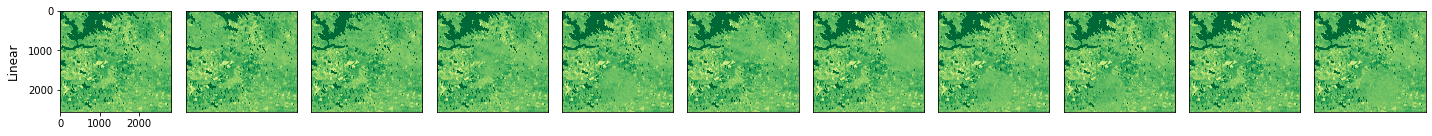

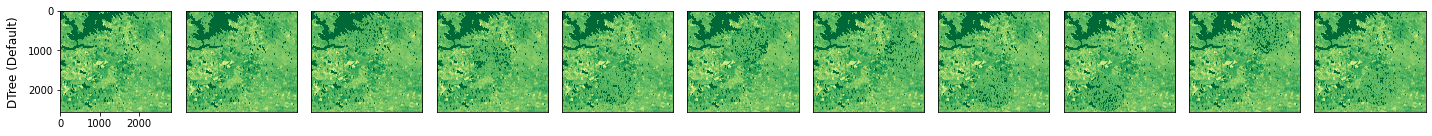

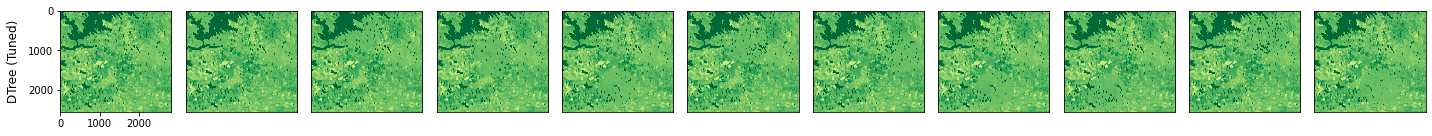

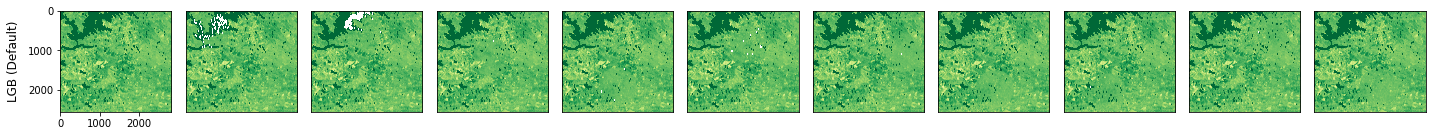

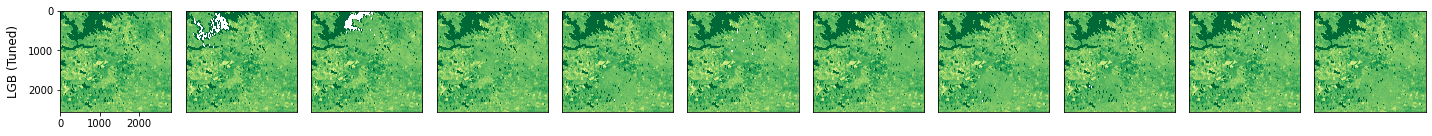

In [60]:
##Plot shifted NIR images

##make outputfiles
save_names = [f"Cloud_Images_NDVI_aoi_{choose_ind}.png", f"Linear_Pred_NDVI_aoi_{choose_ind}.png", f"DTree_Pred_NDVI_aoi_{choose_ind}.png", 
              f"DTree_Tuned_Pred_NDVI_aoi_{choose_ind}.png",
              f"LGB_Pred_NDVI_aoi_{choose_ind}.png",f"LGB_Tuned_Pred_NDVI_aoi_{choose_ind}.png"]
save_paths = [join(output_dir, f) for f in save_names]



##Loop through to plot clouds + models
for i in range(len(titles)):

  if i == 0:
    process_cloud = True; set_title = True
  else:
    process_cloud = False; set_title = False

  plot_images2(original_raster_filename=original_raster_filename, predicted_filename_list = prediction_file_list[i], 
                raster_rgba_order = raster_rgba_order, color_plot_order = shifted_order, figsize = (20,15), y_label = titles[i],
                process_cloud = process_cloud, set_title = set_title, NDVI = True, save = True, save_path = save_paths[i])
  
  del process_cloud, set_title

In [ ]:
gc.collect()
